# Exercise 3

Team members: Agata Kaczmarek (uni-id), Mateusz Stączek (uni-id)

## 1. Two moons with an invertible neural network

We repeat task 2 from exercise 02 with a normalizing flow. That is, use a RealNVP network to train a generative model p(x) for the two moons dataset. A RealNVP consists of coupling blocks, where the second half of the dimensions is transformed by a linear function whose coefficients depend on the first half. The coefficients are calculated with nested neural networks with two hidden layers (with ReLU activation) and a linear output layer (for the translation coefficient) resp. a linear layer followed by $\exp(\tanh(\tilde{s}))$
(for the scaling coefficient). The width of these internal networks is a hyperparameter and may be larger than the data dimension. The first half of the dimensions is just forwared by a skip connection. After each coupling layer (except for the last), a random orthogonormal matrix is inserted to rotate the space, so that the skip connection is not always applied to the same dimensions. 

The RealNVP's constructor should have three arguments:
- input_size: the data dimension (= 2 for the two moons dataset)
- hidden_size: the width of the nested networks
- blocks: the number of coupling blocks

Implement the encoder as the forward pass through the network, and the decoder as the reverse
pass. 

In [3]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

/shared-libs/python3.9/py/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<div style="color: green; font-weight:bold">
Essentially equal: make_moons and load_digits could be imported in a single line
</div>

In [4]:
class CouplingBlock(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(CouplingBlock, self).__init__()
        
        # d_tilde is size of what will be transformed
        self.d_tilde = input_size // 2

        # 2 hidden layers with ReLU activation and linear output layer. exp and tanh are applied later
        self.scale_network = nn.Sequential(
            nn.Linear(self.d_tilde, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, self.d_tilde),
            nn.Tanh(),
        )
        
        # 2 hidden layers with ReLU activation and linear output layer
        self.translation_network = nn.Sequential(
            nn.Linear(self.d_tilde, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, self.d_tilde),
        )

    def forward(self, x):
        x1 = x[:, :self.d_tilde] # d_tilde is the size of what will be transformed
        x2 = x[:, self.d_tilde:] 
        
        z1 = x1

        s = self.scale_network(x1)
        t = self.translation_network(x1)
        z2 = torch.exp(torch.tanh(s)) * x2 + t

        z = torch.cat([z1, z2], dim=1)

        log_det_jacobian = torch.sum(torch.tanh(s), dim=1) # log removes exp, but tanh remains

        return z, log_det_jacobian
    
    def inverse(self, z):
        z1 = z[:, :self.d_tilde]
        z2 = z[:, self.d_tilde:]

        x1 = z1

        s = self.scale_network(x1)
        t = self.translation_network(x1)

        x2 = (z2 - t) * torch.exp(-1 * torch.tanh(s)) # came from earlier: z2 = torch.exp(torch.tanh(s)) * x2 + t
              
        x = torch.cat([x1, x2], dim=1)

        return x

class RealNVP_1(nn.Module):
    def __init__(self, input_size, hidden_size, blocks):
        super(RealNVP_1, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.blocks = blocks

        self.layers = nn.ModuleList([CouplingBlock(self.input_size, self.hidden_size) for _ in range(self.blocks)])
        
        self.orthonormal_matrices = []
        self.orthonormal_matrices_T = []
        for i in range(self.blocks-1):
            matrix = self._get_orthonormal_matrix(self.input_size)
            self.orthonormal_matrices.append(matrix)
            self.orthonormal_matrices_T.append(torch.transpose(matrix, 0, 1)) # for inverse pass (decoder)

    def _get_orthonormal_matrix(self, size):
        Q, _ = torch.linalg.qr(torch.randn(size, size))
        return nn.Parameter(Q, requires_grad=False)
        
    def encoder(self, x):
        log_det_jacobian_sum = 0
        for i in range(self.blocks):
            x, log_det_jacobian = self.layers[i](x)
            log_det_jacobian_sum += log_det_jacobian
            if i < self.blocks - 1:
                x = torch.matmul(x, self.orthonormal_matrices[i])
        return x, log_det_jacobian_sum
    
    def decoder(self, z):
        for i in range(self.blocks - 1, -1, -1):
            if i < self.blocks - 1:
                z = torch.matmul(z, self.orthonormal_matrices_T[i]) # use transposed orthonormal matrix to undo it's effect
            z = self.layers[i].inverse(z)
        return z

    def forward(self, x):
        z, log_det_jacobian_sum = self.encoder(x)
        return z, log_det_jacobian_sum
    
    def sample(self, num_samples):
        z = torch.randn(num_samples, self.input_size)
        samples = self.decoder(z)
        return samples

<div style="color: green; font-weight:bold">
Coupling Blocks:

Our solution is different and in some places incorrect:
- In coupling blocks, the correct solution contains a single network that accepts as input the first half of the dimensions and outputs a vector twice the size of the second half of the dimensions, that contains scale and translate parts. Our implementation has two separate networks, one for scale and one for translate. This differs from the correct solution, but we believe we implemented it the same way as it was presented during the lecture.
- In coupling blocks, we apply tanh function twice to the scale network output instead of once. This reduces the range of possible values from (-1,1) to (-0.76,0.76). This is not a big deal, but it is different than what we had to do.

Handling forward and reverse passes in coupling blocks is more elegant in the correct solution.

Other than that, Coupling Blocks are implemented same as in the correct solution.

----

RealNVP class:

Our solution is different:
- the correct solution named 'blocks' parameter 'n_blocks' which is different than the task description stated. We followed the task description.
- we create orthogonal matrices using QR decomposition and the correct solution uses a more complex special_ortho_group.rvs(...) function, but this is valid alternative. Also, we named the variables 'orthonormal' instead of 'orthogonal', but it does not matter.
- log of determinant of Jacobian matrices returned by our coupling blocks is a single number and the correct solution returns a whole vector, which is later summed. The solutions are equivalent.

Other than that, our implementation is the same as the correct solution.
</div>

Furthermore, implement a training function train_inn() (for "invertible neural network") using
the torch.optim.Adam optimizer with default learning rate lr=0.001 and the negative log-likelihood loss, as explained in the lecture. 

Training has again three hyperparameters: 
- the size of the training set, 
- the number of epochs, 
- and the learning rate. 

During design and debugging of your code, your should start small (e.g. 1000 training points, 10 epochs, 2 layers) to ensure rapid training. Gradually increase network size and training effort once your results start looking promising. As a basic check, make sure that the reverse pass is the exact inverse of the forward pass, up to tiny numerical errors.

In [ ]:
# basic check
x_original = torch.randn(2, 8)
model = RealNVP_1(8, 16, 10)
x_forward_backward = model.decoder(model.encoder(x_original)[0])
x_original, x_forward_backward

(tensor([[ 1.9096,  2.0113,  0.4136,  1.9742, -1.2030,  1.6645,  1.2391,  0.2338],
         [-1.5109, -1.0470, -1.4097,  0.5315, -0.5307,  0.5372,  0.3105,  0.4331]]),
 tensor([[ 1.9096,  2.0113,  0.4136,  1.9742, -1.2030,  1.6645,  1.2391,  0.2338],
         [-1.5109, -1.0470, -1.4097,  0.5315, -0.5307,  0.5372,  0.3105,  0.4331]],
        grad_fn=<CatBackward0>))

<div style="color: green; font-weight:bold">
Correct.
</div>

In [5]:
def custom_negative_log_likelihood_loss(model_outputs, log_det_jacobian_sum):
    return torch.mean(torch.sum(0.5 * torch.pow(model_outputs, 2), dim=1) - log_det_jacobian_sum)

def train_inn(model, X_train, X_test, n_epochs, batch_size, learning_rate=0.001, size_of_the_training_set=-1, loss_function=custom_negative_log_likelihood_loss):
    """
    Args:
        model (nn.Module): a RealNVP model which returns z and log_det_jacobian_sum
        X_train (np.ndarray): the training data
        X_test (np.ndarray): the test data
        n_epochs (int): the number of training epochs
        batch_size (int): the batch size
        learning_rate (float): the learning rate
        size_of_the_training_set (int): subset of the training set to use (default: -1, i.e. use the whole training set)
        loss_function (function): the loss function to use (default: custom_negative_log_likelihood_loss)
    """
    criterion = loss_function
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    test_losses = []

    X_train = X_train[:size_of_the_training_set]
    
    data_train = torch.from_numpy(X_train).float()
    data_test = torch.from_numpy(X_test).float()

    # loss before training
    with torch.no_grad():
        z, log_det_jacobian_sum = model(data_train)
        loss = criterion(z, log_det_jacobian_sum)
        train_losses.append(loss.item())
        z, log_det_jacobian_sum = model(data_test)
        loss = criterion(z, log_det_jacobian_sum)
        test_losses.append(loss.item())
    print(f"Epoch 0/{n_epochs}: train_loss={train_losses[-1]:.4f}, test_loss={test_losses[-1]:.4f}")

    # trainning
    for epoch in range(n_epochs):
        train_loss = 0
        test_loss = 0
        for i in range(0, len(X_train), batch_size):
            data = data_train[i:i+batch_size]
            optimizer.zero_grad()
            z, log_det_jacobian_sum = model(data)
            loss = criterion(z, log_det_jacobian_sum)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * len(data)
        train_loss /= len(X_train)
        train_losses.append(train_loss)

        with torch.no_grad():
            for i in range(0, len(X_test), batch_size):
                data = data_test[i:i+batch_size]
                z, log_det_jacobian_sum = model(data)
                loss = criterion(z, log_det_jacobian_sum)
                test_loss += loss.item() * len(data)
            test_loss /= len(X_test)
            test_losses.append(test_loss)
            
        if (epoch+1) % (n_epochs//10+1) == 0 or epoch == n_epochs-1:
            print(f"Epoch {epoch+1}/{n_epochs}: train_loss={train_loss:.4f}, test_loss={test_loss:.4f}")
    df = pd.DataFrame({'train': train_losses, 'test': test_losses, 'epoch': list(range(n_epochs+1))})
    return df

<div style="color: green; font-weight:bold">
Differs but is a valid alternative. 
<br><br>
We believe, that the correct solution should not sample new two_moons data at each training epoch. It is inefficient.
</div>

In [6]:
def get_moons_data(n_train, n_test=1000, noise=0.1, random_state=123):
    """
    Generate data from make_moons.
    """
    X_train, y_train = make_moons(n_samples=n_train, noise=noise, random_state=random_state)
    X_test, y_test = make_moons(n_samples=n_test, noise=noise, random_state=random_state+1)
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = get_moons_data(1000, 200, noise=0.1)

<div style="color: green; font-weight:bold">
Ok.
</div>

When your code works, train and evaluate the RealNVP with two moons at noise level 0.1. 

In [7]:
def plot_model_details(model, X_train, y_train, title="Model details"):
    with torch.no_grad():
        Z_train = model(torch.from_numpy(X_train).float())[0]
        X_decoded = model.decoder(Z_train)
        Z_train = Z_train.detach().numpy()
        Z_noise = torch.randn((1000, X_train.shape[1]))
        X_noise = model.decoder(Z_noise).detach().numpy()

    fig, axs = plt.subplots(1, 4, figsize=(12, 4))
    fig.suptitle(title, y=0.92)
    axs[0].scatter(Z_train[:, 0], Z_train[:, 1], c=y_train, s=3)
    axs[0].set_title("Train set encoded")
    axs[0].set_aspect('equal')
    axs[1].scatter(X_decoded[:, 0], X_decoded[:, 1], c=y_train, s=3)
    axs[1].set_title("Train set decoded\nsame as original")
    axs[1].set_aspect('equal')
    axs[2].scatter(Z_noise[:, 0], Z_noise[:, 1], c="blue", s=3)
    axs[2].set_title("Gaussian random")
    axs[2].set_aspect('equal')
    axs[3].scatter(X_noise[:, 0], X_noise[:, 1], c="blue", s=3)
    axs[3].set_title("Noise decoded")
    axs[3].set_aspect('equal')
    plt.show()   

<div style="color: green; font-weight:bold">
Ok.
</div>

In [8]:
def plot_training_losses(df, title="Training losses", starting_epoch=0):
    fig, ax = plt.subplots(figsize=(6, 4))
    fig.suptitle(title)
    ax.plot(df['epoch'], df['train'], label="Train")
    ax.plot(df['epoch'], df['test'], label="Test")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    max_val = max(df['train'][starting_epoch:].max(), df['test'][starting_epoch:].max())
    min_val = min(df['train'][starting_epoch:].min(), df['test'][starting_epoch:].min())
    ax.set_ylim(top=max_val,
                bottom=min_val - 0.1 * (max_val - min_val))
    ax.axvline(x=0, linestyle='--', color='gray')
    ax.legend(title="Loss")
    plt.show()

<div style="color: green; font-weight:bold">
Ok.
</div>

Epoch 0/1000: train_loss=1.2490, test_loss=1.2445
Epoch 101/1000: train_loss=-0.8097, test_loss=-0.7059
Epoch 202/1000: train_loss=-0.8515, test_loss=-0.6882
Epoch 303/1000: train_loss=-0.8998, test_loss=-0.6647
Epoch 404/1000: train_loss=-0.8589, test_loss=-0.6517
Epoch 505/1000: train_loss=-0.8557, test_loss=-0.6513
Epoch 606/1000: train_loss=-0.9174, test_loss=-0.7030
Epoch 707/1000: train_loss=-0.8881, test_loss=-0.6550
Epoch 808/1000: train_loss=-0.9464, test_loss=-0.6596
Epoch 909/1000: train_loss=-0.9191, test_loss=-0.6604
Epoch 1000/1000: train_loss=-0.9689, test_loss=-0.6447


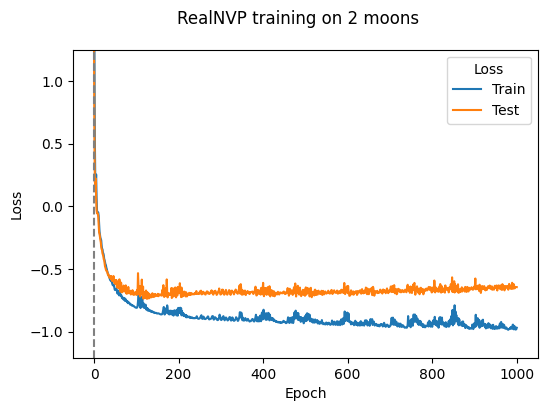

In [9]:
model = RealNVP_1(2, 128, 8)
df = train_inn(model=model, X_train=X_train, X_test=X_test, 
               n_epochs=1000, # above 200 is fine, 1000 for good sampling
               batch_size=1000, # over whole dataset is faster than over small batches
               learning_rate=0.001)

plot_training_losses(df, title="RealNVP training on 2 moons", starting_epoch=0)

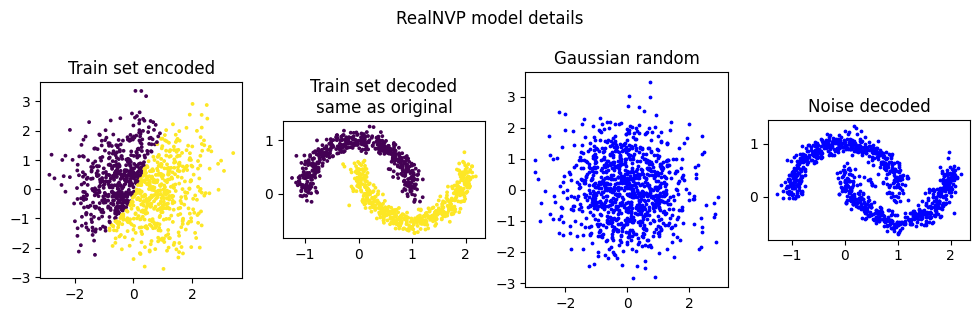

In [ ]:
plot_model_details(model, X_train, y_train, title="RealNVP model details")

<div style="color: green; font-weight:bold">
Ok, we could add details about model such as sizes of layers, number of blocks, etc. to titles as in the correct solution.
</div>

Investigate systematically the effect of the hyperparameters on model quality. Check if the code distribution is indeed standard normal. Note, however, that looking at reconstructions errors is pointless, because they are zero by design, as long as there is no bug. 

In [10]:
from scipy.stats import shapiro

def check_distribution(model, X_train, y_train, title="Model details"):
    with torch.no_grad():
        Z_train = model(torch.from_numpy(X_train).float())[0]
        Z_train = Z_train.detach().numpy()
        Z_noise = torch.randn((X_train.shape[0], X_train.shape[1]))

    result_num=np.round(shapiro(Z_train).pvalue,3)
    if result_num>0.05:
        result=str(result_num)+", is standard normal."
    else:
        result=str(result_num)+", not standard normal."

    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f"{title} and Shapiro Wilk Test result: {result}", y=1)
    axs[0].scatter(Z_train[:, 0], Z_train[:, 1], c=y_train, s=3)
    axs[0].set_title("Train set encoded")
    axs[0].set_aspect('equal')
    axs[1].scatter(Z_noise[:, 0], Z_noise[:, 1], c="blue", s=3)
    axs[1].set_title("Gaussian random")
    axs[1].set_aspect('equal')
    plt.show()   

<div style="color: green; font-weight:bold">
Ok.
</div>

In [11]:
#hyperparameters: the size of the training set, the number of epochs, and the learning rate. 

def investigate_hyperparams(training_set_size=1000, num_epochs=1000, lr=0.001):
    X_train, y_train, X_test, y_test = get_moons_data(training_set_size, 200, noise=0.1)
    model = RealNVP_1(2, 128, 8)
    df = train_inn(model=model, X_train=X_train, X_test=X_test, 
                n_epochs=num_epochs, # above 200 is fine, 1000 for good sampling
                batch_size=training_set_size, # over whole dataset is faster than over small batches
                learning_rate=lr)

    plot_training_losses(df, title=f"RealNVP training, train set size: {training_set_size}, epochs: {num_epochs}, lr: {lr}", starting_epoch=0)
    check_distribution(model, X_train, y_train, title="Model details")
    return model

<div style="color: green; font-weight:bold">
Ok.
</div>

Start
Epoch 0/1000: train_loss=0.3579, test_loss=0.3708
Epoch 101/1000: train_loss=-0.9994, test_loss=1.9613
Epoch 202/1000: train_loss=-1.0552, test_loss=6.8706
Epoch 303/1000: train_loss=-1.0971, test_loss=1.3272
Epoch 404/1000: train_loss=-1.2704, test_loss=1.9554
Epoch 505/1000: train_loss=-1.1929, test_loss=2.1388
Epoch 606/1000: train_loss=-1.2441, test_loss=1.6665
Epoch 707/1000: train_loss=-1.4403, test_loss=3.5006
Epoch 808/1000: train_loss=-1.4086, test_loss=2.5756
Epoch 909/1000: train_loss=-1.5335, test_loss=5.6265
Epoch 1000/1000: train_loss=-1.4136, test_loss=4.0156


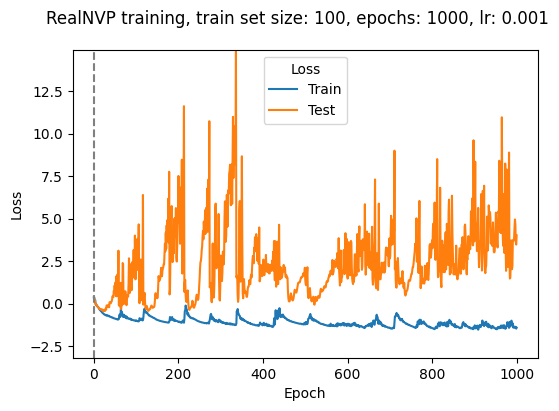

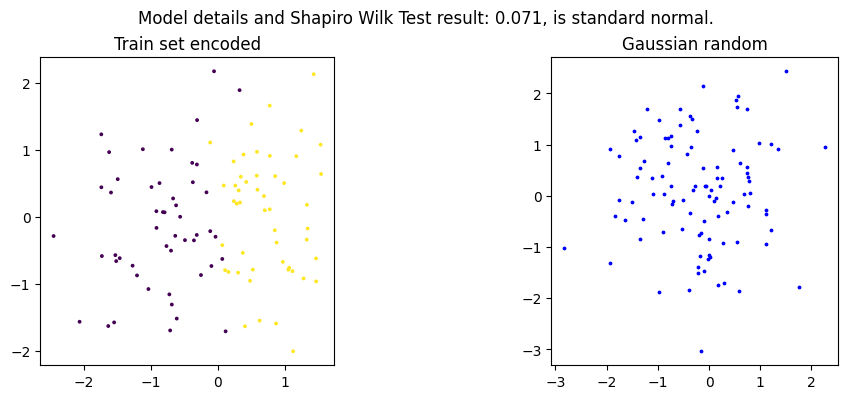

Done:100
Epoch 0/1000: train_loss=0.9267, test_loss=0.9251
Epoch 101/1000: train_loss=-0.6334, test_loss=-0.3251
Epoch 202/1000: train_loss=-0.9761, test_loss=-0.3504
Epoch 303/1000: train_loss=-0.7888, test_loss=-0.1969
Epoch 404/1000: train_loss=-0.8058, test_loss=-0.1842
Epoch 505/1000: train_loss=-1.0747, test_loss=-0.3126
Epoch 606/1000: train_loss=-0.6451, test_loss=-0.2645
Epoch 707/1000: train_loss=-0.9905, test_loss=-0.2416
Epoch 808/1000: train_loss=-0.9918, test_loss=-0.3000
Epoch 909/1000: train_loss=-1.1940, test_loss=0.6839
Epoch 1000/1000: train_loss=-1.2873, test_loss=0.6644


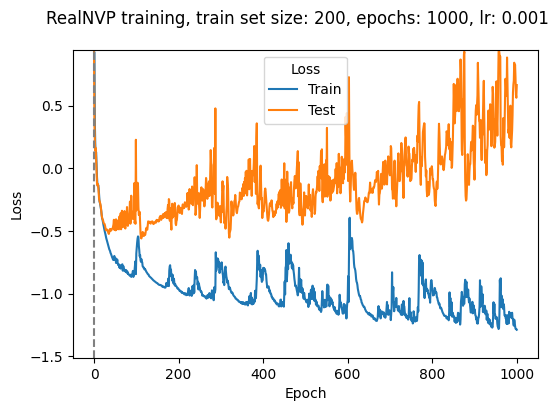

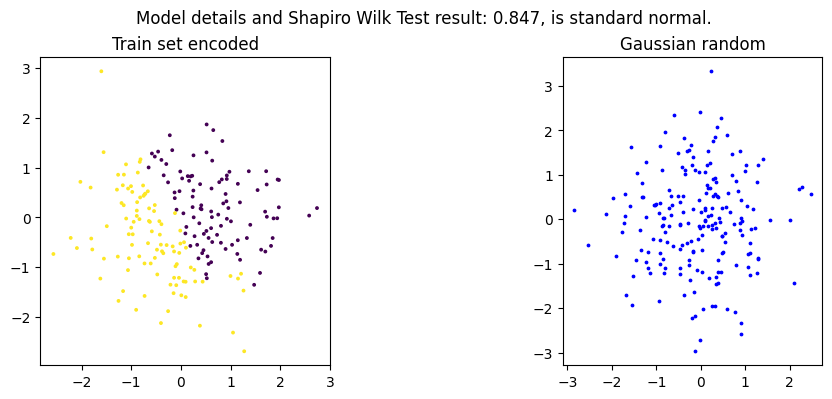

Done:200
Epoch 0/1000: train_loss=0.8263, test_loss=0.8233
Epoch 101/1000: train_loss=-0.7605, test_loss=-0.6976
Epoch 202/1000: train_loss=-0.8387, test_loss=-0.7027
Epoch 303/1000: train_loss=-0.8809, test_loss=-0.6722
Epoch 404/1000: train_loss=-0.9030, test_loss=-0.6322
Epoch 505/1000: train_loss=-0.9083, test_loss=-0.6041
Epoch 606/1000: train_loss=-0.8719, test_loss=-0.5699
Epoch 707/1000: train_loss=-0.9483, test_loss=-0.5340
Epoch 808/1000: train_loss=-0.9576, test_loss=-0.5130
Epoch 909/1000: train_loss=-0.9652, test_loss=-0.4782
Epoch 1000/1000: train_loss=-0.8923, test_loss=-0.4088


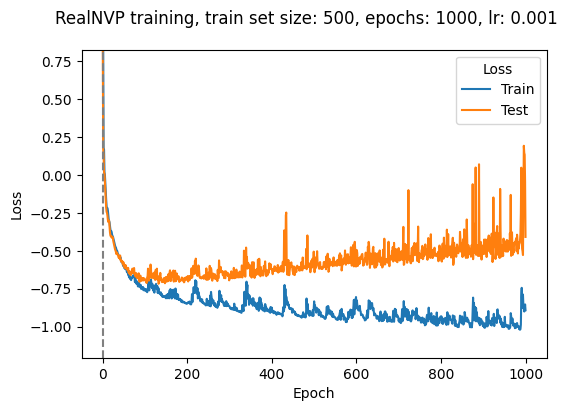

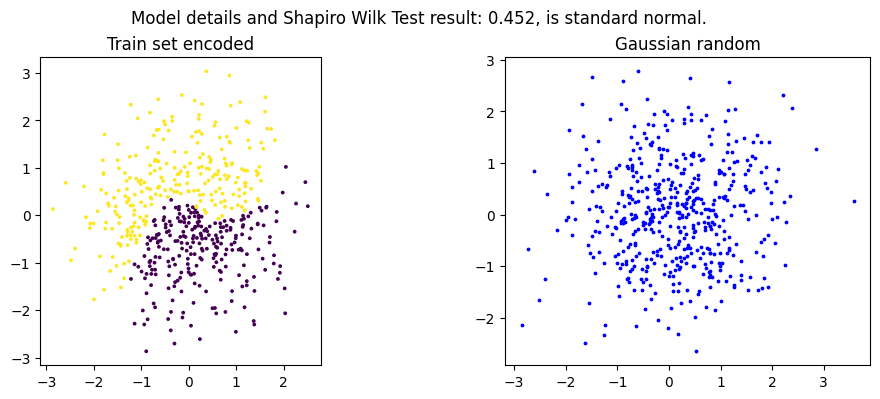

Done:500
Epoch 0/1000: train_loss=0.9026, test_loss=0.9064
Epoch 101/1000: train_loss=-0.7391, test_loss=-0.7325
Epoch 202/1000: train_loss=-0.7842, test_loss=-0.7195
Epoch 303/1000: train_loss=-0.8839, test_loss=-0.8183
Epoch 404/1000: train_loss=-0.8495, test_loss=-0.8116
Epoch 505/1000: train_loss=-0.8607, test_loss=-0.8169
Epoch 606/1000: train_loss=-0.9163, test_loss=-0.8260
Epoch 707/1000: train_loss=-0.9342, test_loss=-0.8157
Epoch 808/1000: train_loss=-0.9053, test_loss=-0.7822
Epoch 909/1000: train_loss=-0.9126, test_loss=-0.6969
Epoch 1000/1000: train_loss=-0.9526, test_loss=-0.6707


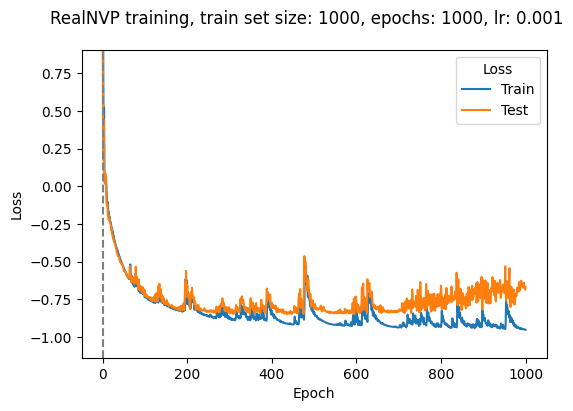

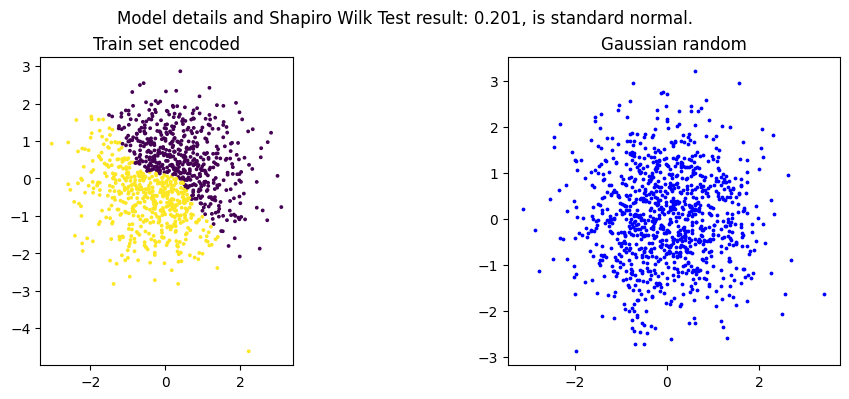

Done:1000
Epoch 0/10: train_loss=0.8816, test_loss=0.8786
Epoch 2/10: train_loss=0.2547, test_loss=0.0812
Epoch 4/10: train_loss=0.0327, test_loss=0.0576
Epoch 6/10: train_loss=0.0189, test_loss=-0.1166
Epoch 8/10: train_loss=-0.1741, test_loss=-0.1860
Epoch 10/10: train_loss=-0.1647, test_loss=-0.1707


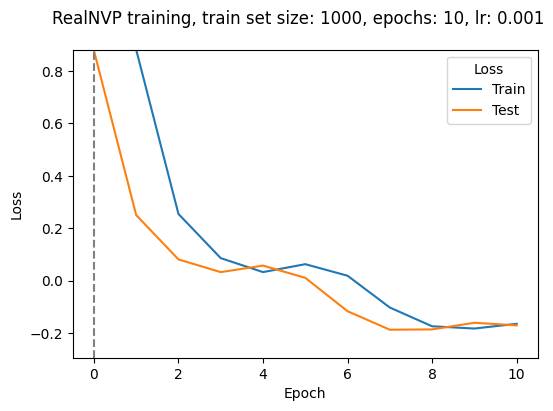

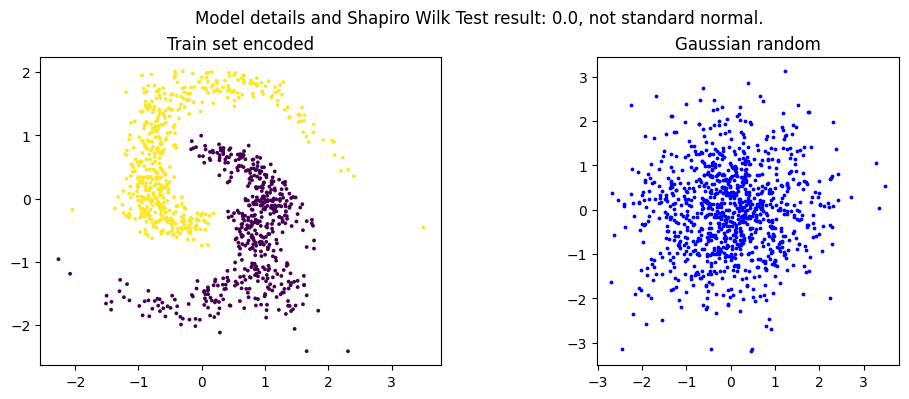

Done:10
Epoch 0/50: train_loss=0.9120, test_loss=0.8977
Epoch 6/50: train_loss=0.1157, test_loss=0.0641
Epoch 12/50: train_loss=-0.1427, test_loss=-0.1425
Epoch 18/50: train_loss=-0.2944, test_loss=-0.2713
Epoch 24/50: train_loss=-0.3923, test_loss=-0.3972
Epoch 30/50: train_loss=-0.4901, test_loss=-0.4909
Epoch 36/50: train_loss=-0.5610, test_loss=-0.5388
Epoch 42/50: train_loss=-0.6209, test_loss=-0.5894
Epoch 48/50: train_loss=-0.5819, test_loss=-0.5559
Epoch 50/50: train_loss=-0.5854, test_loss=-0.5544


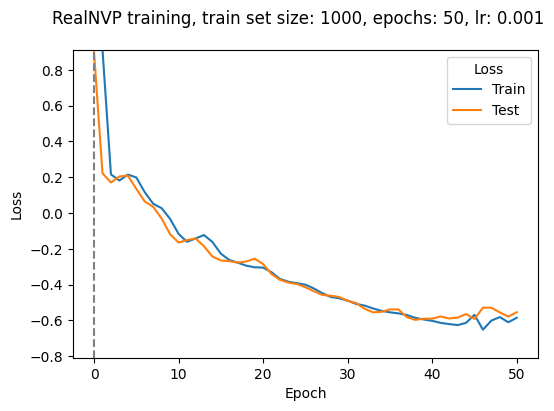

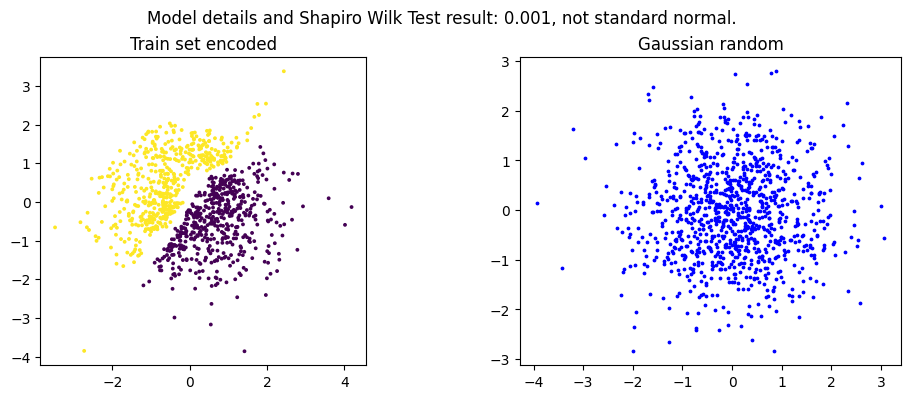

Done:50
Epoch 0/100: train_loss=0.7261, test_loss=0.7288
Epoch 11/100: train_loss=-0.1328, test_loss=-0.1679
Epoch 22/100: train_loss=-0.3101, test_loss=-0.3286
Epoch 33/100: train_loss=-0.4889, test_loss=-0.5106
Epoch 44/100: train_loss=-0.5244, test_loss=-0.5390
Epoch 55/100: train_loss=-0.5854, test_loss=-0.5287
Epoch 66/100: train_loss=-0.6664, test_loss=-0.6193
Epoch 77/100: train_loss=-0.7019, test_loss=-0.6856
Epoch 88/100: train_loss=-0.6059, test_loss=-0.3844
Epoch 99/100: train_loss=-0.6854, test_loss=-0.6231
Epoch 100/100: train_loss=-0.5851, test_loss=-0.6255


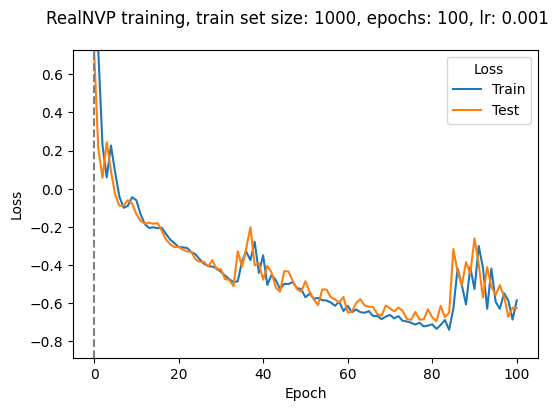

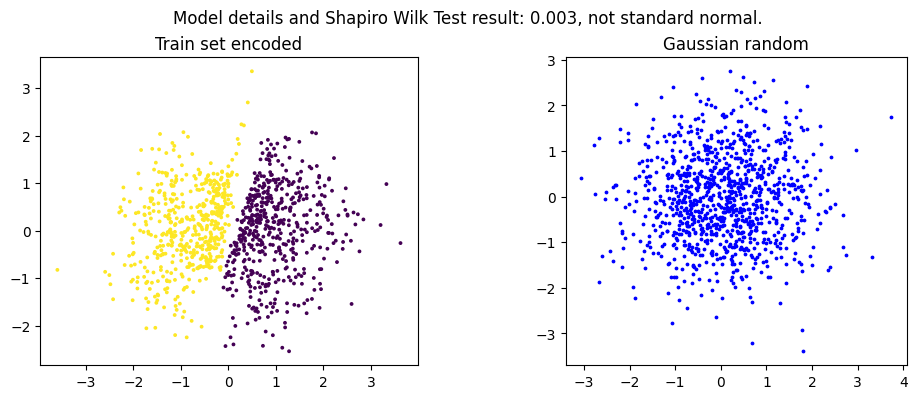

Done:100
Epoch 0/200: train_loss=0.9085, test_loss=0.9110
Epoch 21/200: train_loss=-0.3059, test_loss=-0.3340
Epoch 42/200: train_loss=-0.4687, test_loss=-0.4700
Epoch 63/200: train_loss=-0.4184, test_loss=-0.4843
Epoch 84/200: train_loss=-0.6187, test_loss=-0.5964
Epoch 105/200: train_loss=-0.7177, test_loss=-0.6501
Epoch 126/200: train_loss=-0.7510, test_loss=-0.6565
Epoch 147/200: train_loss=-0.7128, test_loss=-0.6513
Epoch 168/200: train_loss=-0.7755, test_loss=-0.6743
Epoch 189/200: train_loss=-0.7885, test_loss=-0.6658
Epoch 200/200: train_loss=-0.7751, test_loss=-0.6749


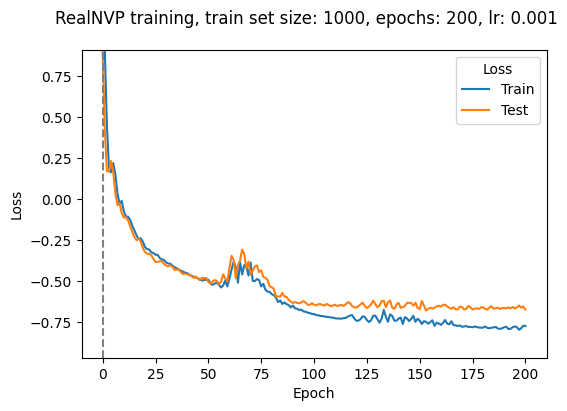

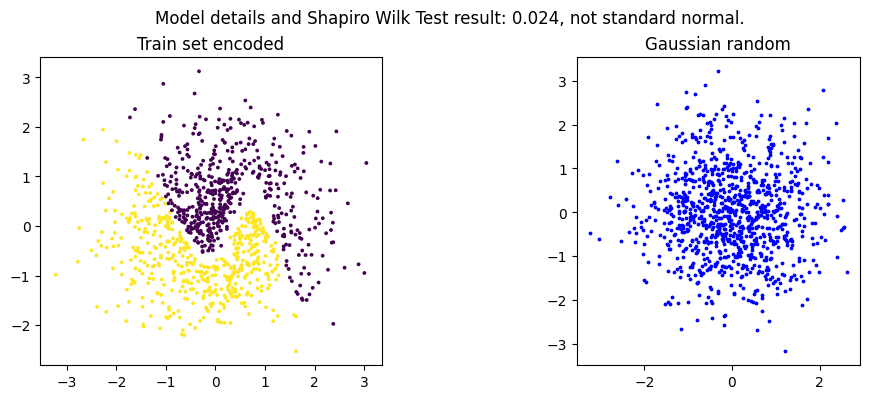

Done:200
Epoch 0/1000: train_loss=0.8992, test_loss=0.9043
Epoch 101/1000: train_loss=-0.7189, test_loss=-0.6743
Epoch 202/1000: train_loss=-0.8610, test_loss=-0.7955
Epoch 303/1000: train_loss=-0.8908, test_loss=-0.7914
Epoch 404/1000: train_loss=-0.9019, test_loss=-0.7770
Epoch 505/1000: train_loss=-0.8744, test_loss=-0.6963
Epoch 606/1000: train_loss=-0.9308, test_loss=-0.6538
Epoch 707/1000: train_loss=-0.9191, test_loss=-0.5794
Epoch 808/1000: train_loss=-0.9513, test_loss=-0.5438
Epoch 909/1000: train_loss=-0.9418, test_loss=-0.4774
Epoch 1000/1000: train_loss=-0.9117, test_loss=-0.5635


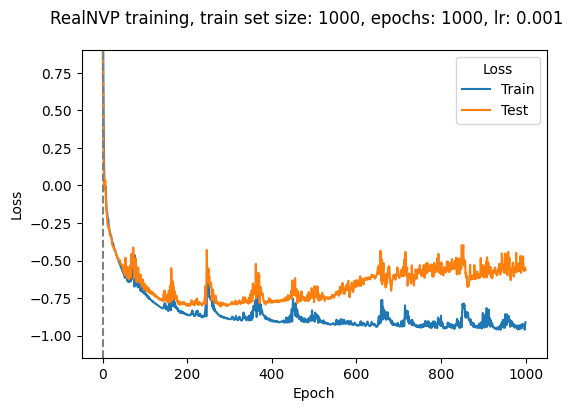

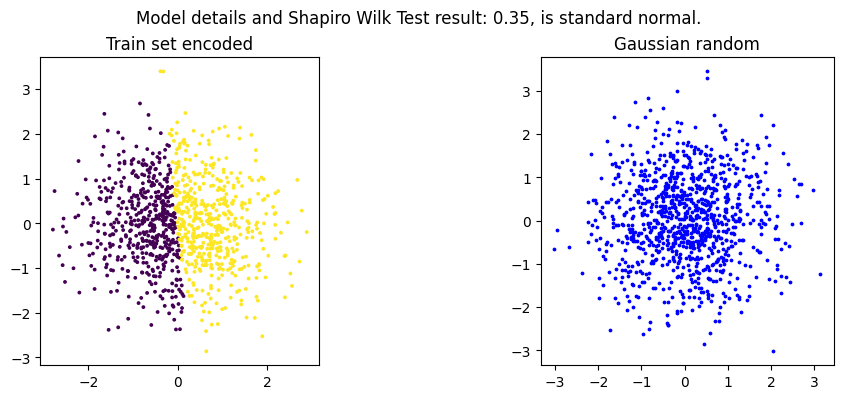

Done:1000
Epoch 0/1000: train_loss=0.5582, test_loss=0.5705
Epoch 101/1000: train_loss=-0.7964, test_loss=-0.6872
Epoch 202/1000: train_loss=-0.8903, test_loss=-0.7225
Epoch 303/1000: train_loss=-0.8998, test_loss=-0.7457
Epoch 404/1000: train_loss=-0.9268, test_loss=-0.6946
Epoch 505/1000: train_loss=-0.9325, test_loss=-0.7027
Epoch 606/1000: train_loss=-0.9459, test_loss=-0.6759
Epoch 707/1000: train_loss=-0.9553, test_loss=-0.6360
Epoch 808/1000: train_loss=-0.9406, test_loss=-0.6684
Epoch 909/1000: train_loss=-0.9690, test_loss=-0.6318
Epoch 1000/1000: train_loss=-0.9794, test_loss=-0.5861


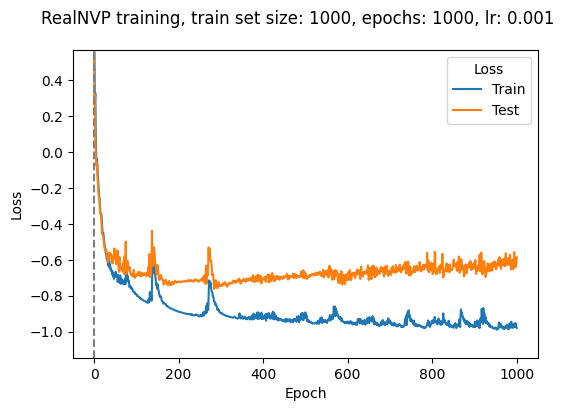

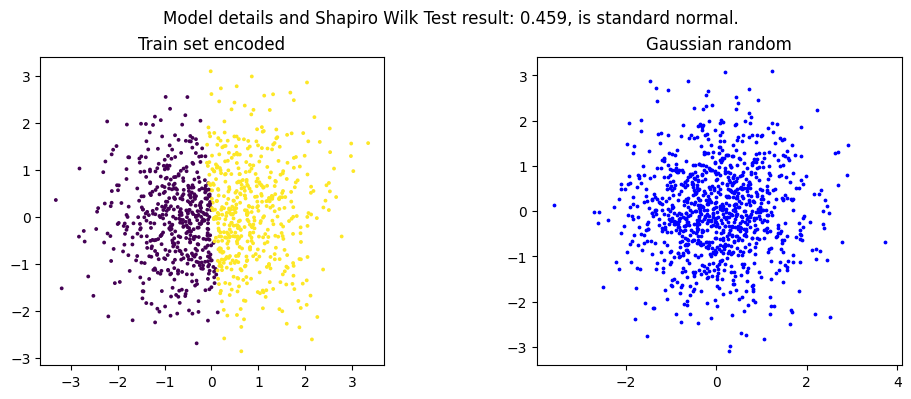

Done:0.001
Epoch 0/1000: train_loss=1.0607, test_loss=1.0609
Epoch 101/1000: train_loss=-0.3028, test_loss=-0.3048
Epoch 202/1000: train_loss=-0.6498, test_loss=-0.5783
Epoch 303/1000: train_loss=-0.7084, test_loss=-0.6374
Epoch 404/1000: train_loss=-0.7838, test_loss=-0.6488
Epoch 505/1000: train_loss=-0.8088, test_loss=-0.6259
Epoch 606/1000: train_loss=-0.7239, test_loss=-0.4227
Epoch 707/1000: train_loss=-0.4741, test_loss=-0.5616
Epoch 808/1000: train_loss=-0.8507, test_loss=-0.6113
Epoch 909/1000: train_loss=-0.8286, test_loss=-0.5183
Epoch 1000/1000: train_loss=-0.8666, test_loss=-0.6584


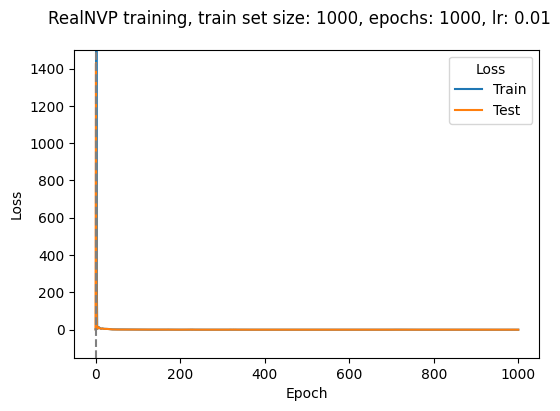

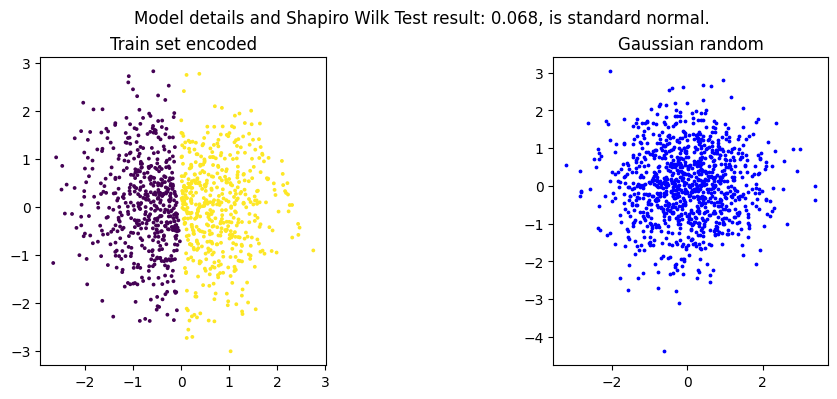

Done:0.01
Epoch 0/1000: train_loss=1.0507, test_loss=1.0516
Epoch 101/1000: train_loss=74958856.0000, test_loss=136143036416.0000
Epoch 202/1000: train_loss=487735616.0000, test_loss=455345760.0000
Epoch 303/1000: train_loss=111080424.0000, test_loss=103231920.0000
Epoch 404/1000: train_loss=22141048.0000, test_loss=20722712.0000
Epoch 505/1000: train_loss=5427995.0000, test_loss=5107024.5000
Epoch 606/1000: train_loss=2296191.2500, test_loss=2171420.7500
Epoch 707/1000: train_loss=2278756.0000, test_loss=2145950.2500
Epoch 808/1000: train_loss=2263380.0000, test_loss=2131910.2500
Epoch 909/1000: train_loss=2246822.5000, test_loss=2116437.5000
Epoch 1000/1000: train_loss=2230831.0000, test_loss=2101892.2500


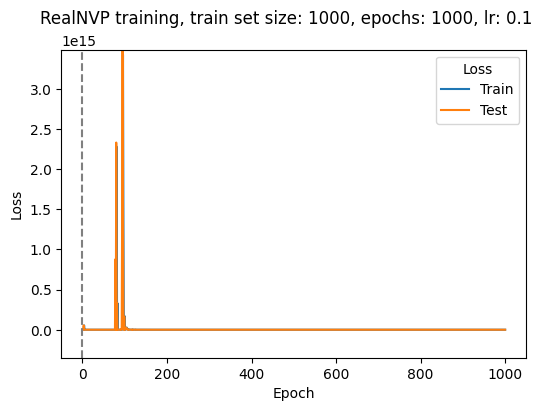

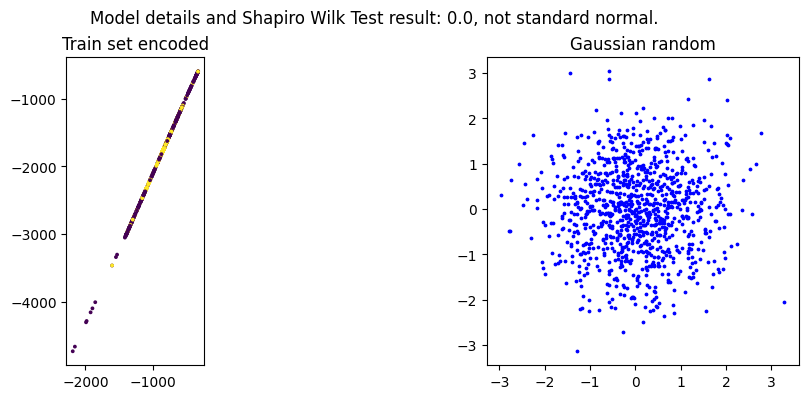

Done:0.1
End


[RealNVP_1(
   (layers): ModuleList(
     (0): CouplingBlock(
       (scale_network): Sequential(
         (0): Linear(in_features=1, out_features=128, bias=True)
         (1): ReLU()
         (2): Linear(in_features=128, out_features=128, bias=True)
         (3): ReLU()
         (4): Linear(in_features=128, out_features=1, bias=True)
         (5): Tanh()
       )
       (translation_network): Sequential(
         (0): Linear(in_features=1, out_features=128, bias=True)
         (1): ReLU()
         (2): Linear(in_features=128, out_features=128, bias=True)
         (3): ReLU()
         (4): Linear(in_features=128, out_features=1, bias=True)
       )
     )
     (1): CouplingBlock(
       (scale_network): Sequential(
         (0): Linear(in_features=1, out_features=128, bias=True)
         (1): ReLU()
         (2): Linear(in_features=128, out_features=128, bias=True)
         (3): ReLU()
         (4): Linear(in_features=128, out_features=1, bias=True)
         (5): Tanh()
       )
      

In [ ]:
#investigating of hyperparameters
size_training_set_list=[100, 200, 500, 1000]
epochs_list=[10, 50, 100, 200, 1000]
lr_list=[0.001, 0.01, 0.1]

models_list=[]
print("Start")
for size in size_training_set_list:
    model1=investigate_hyperparams(training_set_size=size)
    models_list.append(model1)
    print(f"Done:{size}")

for epoch in epochs_list:
    model1=investigate_hyperparams(num_epochs=epoch)
    models_list.append(model1)
    print(f"Done:{epoch}")

for lr in lr_list:
    model1=investigate_hyperparams(lr=lr)
    models_list.append(model1)
    print(f"Done:{lr}")

print("End")
models_list

<div style="color: green; font-weight:bold">
Ok.

A bit too many plots to review them all and a lot of unnecessary text output.
</div>

```
Results:

- The hyperparameters matter. 
- If there is a small training set, the model overfits really fast - after 200 epochs it is clearly visble, and it gets worse. But the generated data can be assumed, that they are from the standard normal distribution, according to the Shapiro Wilk test. 
- When the training set size is 500 and more, the overfitting is not that visible anymore. And the generated data can be assumed, that they are from the standard normal distribution, according to the Shapiro Wilk test. 
- If there are to few epochs (50 or less) - the model is not training enough, the data are not from standard normal. After 70 epochs it starts to have minimal overfitting, but the results start to be meaningful.
- The learning rate 0.001 is good for the training to happen and the code is also good. For values 0.1 and 0.01 the model does not train.

```

<div style="color: green; font-weight:bold">
Ok.
</div>

Furthermore, check the quality of the generated data. To this end, your RealNVP should have a function RealNVP.sample(self, num_samples) that generates the requested number of synthetic points. 

In [12]:
def plot_generated_data(models_list, num_sample=500, title="Generated data"):

    number_of_models=len(models_list) #for us should be 12
    fig, axs = plt.subplots(3, 4, figsize=(12, 4))
    fig.subplots_adjust(left=0.1, bottom=0.1, top=0.9, wspace=0.2,hspace=0.6)
    fig.suptitle(f"{title}", y=1)
    for i, model in enumerate(models_list):
        X_sampled = model.sample(num_samples=num_sample).detach().numpy()
        first=int(i/3)
        second=i-first*3
        axs[second][first].scatter(X_sampled[:, 0], X_sampled[:, 1], s=3)
        axs[second][first].set_title(f"Model {i+1}")
    plt.show()   

<div style="color: green; font-weight:bold">
Ok.
</div>

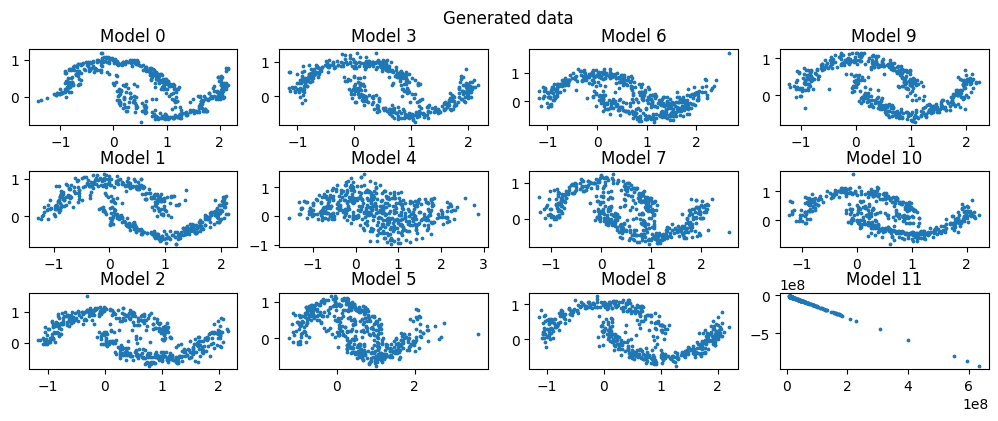

In [ ]:
plot_generated_data(models_list, num_sample=500, title="Generated data")

```
Comment: most of the models was able to generate data, which is similar to the training data for this problem.
```

<div style="color: green; font-weight:bold">
Same as in the correct solution. Adding model details to titles could help as the plots are less informative now.
</div>

Report the MMD between a testset from sklearn.datasets.make_moons and generated points and show that visually better results correspondto smaller MMD. Comment on your observations.

In [13]:
def mmd(dataset_1, dataset_2, bandwidth):
    """
    Function that calculates squared MMD metric.

    Args:
        dataset_1 (torch.Tensor): array of original points.
        dataset_2 (torch.Tensor): array of reconstructed points.
        bandwidth (float): bandwidth of kernel.
    """
    
    M = len(dataset_1)
    part_1 = 0

    for i in range(M):
        for j in range(M):
            part_1 += mmd_kernel_squared_exponential(dataset_1[i], dataset_1[j], bandwidth)
    part_1 /= M * (M - 1)

    N = len(dataset_2)
    part_2 = 0
    for i in range(N):
        for j in range(N):
            part_2 += mmd_kernel_squared_exponential(dataset_2[i], dataset_2[j], bandwidth)
    part_2 /= N * (N - 1)

    part_3 = 0
    for i in range(M):
        for j in range(N):
            part_3 += mmd_kernel_squared_exponential(dataset_1[i], dataset_2[j], bandwidth)
    part_3 *= 2 / (M * N)

    mmd_square = part_1 + part_2 - part_3

    return mmd_square

def mmd_kernel_squared_exponential(x,y,h):
    """
    Function that calculates squared exponential kernel.

    Args:
        x (torch.Tensor): point.
        y (torch.Tensor): point.
        h (float): bandwidth of kernel.
    """
    return  np.exp(-1 * np.linalg.norm(x - y) ** 2 / (2 * h) )

<div style="color: green; font-weight:bold">
Different from the correct solution: 
We use a single bandwidth whereas the correct solution uses a sum over 3 different values of MMD bandwidths. This makes their method more robust to data of different scales.

Correct solution uses additionally scaling parameters beta and gamma and normalization by length of data. Our implementation is simple and follows the lecture.
</div>

In [14]:
def plot_generated_data(models_list, X_test_set, title="Generated data"):

    num_sample=len(X_test_set)
    number_of_models=len(models_list) #for us should be 12
    fig, axs = plt.subplots(3, 4, figsize=(20, 8))
    fig.subplots_adjust(left=0.1, bottom=0.1, top=0.9, wspace=0.2,hspace=0.8)
    fig.suptitle(f"{title}", y=1)
    for i, model in enumerate(models_list):
        X_sampled = model.sample(num_samples=num_sample).detach().numpy()
        first=int(i/3)
        second=i-first*3
        axs[second][first].scatter(X_sampled[:, 0], X_sampled[:, 1], s=3)
        mmd_data=np.round(mmd(X_test_set, X_sampled, 0.5),3)
        axs[second][first].set_title(f"Model {i+1}, MMD: {mmd_data}")
    plt.show()   

<div style="color: green; font-weight:bold">
Ok.
</div>

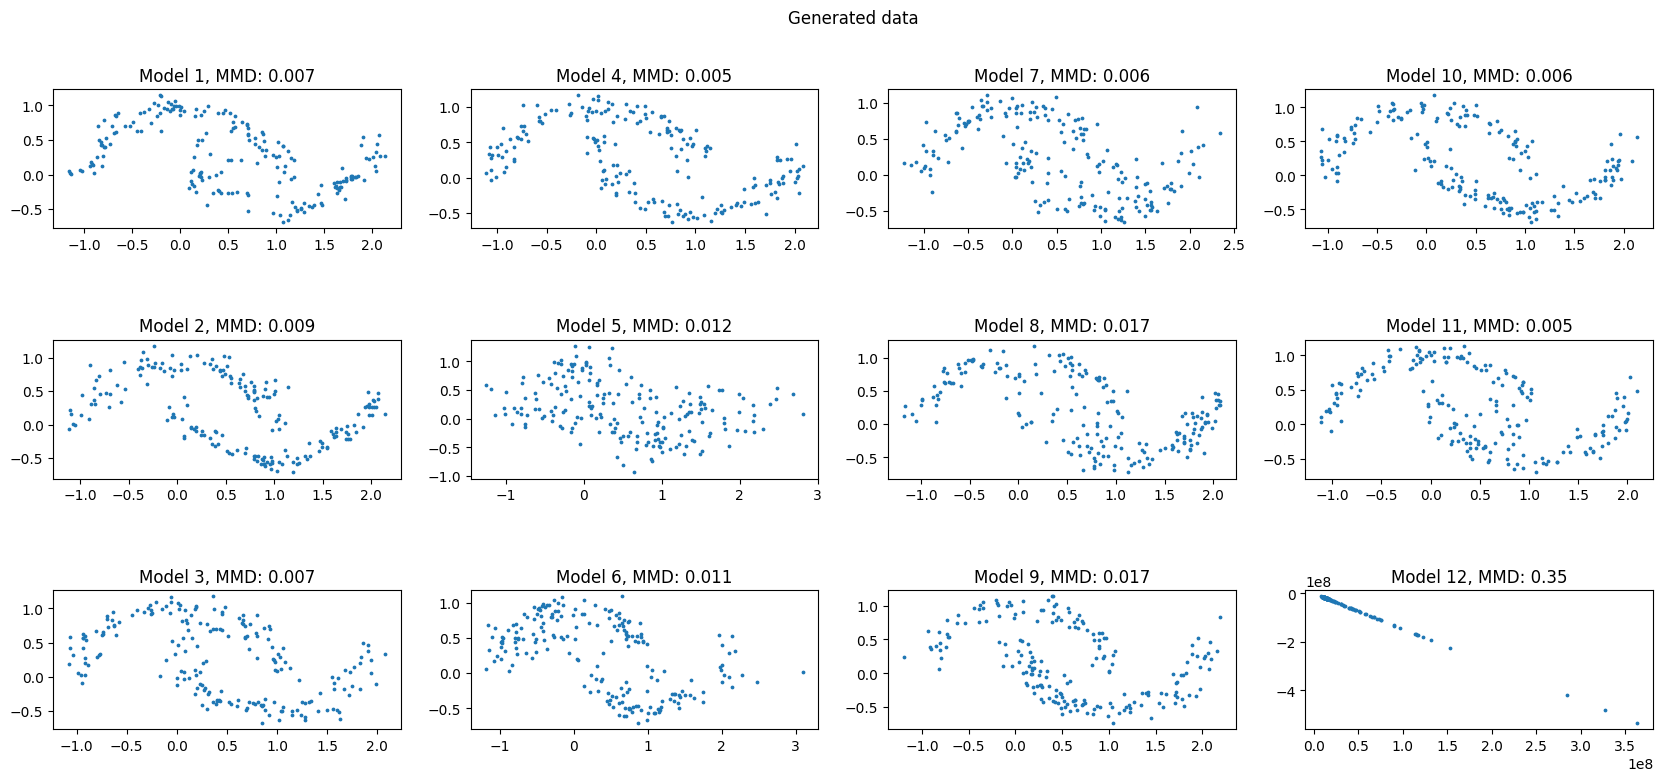

In [ ]:
plot_generated_data(models_list, X_test, title="Generated data")

<div style="color: green; font-weight:bold">
Same as in the correct solution. Adding model details to titles could help as the plots are less informative now. Making dots bigger would make generated data more visible.
</div>

```
Comment:

- As expected, visually better results have smaller MMD. The last model has big MMD value and also the plot shows, the data are poorly reconstructed.
- For model 10, the two moons are clearly visible and the MMD value is 0.006, so really good.
```

<div style="color: green; font-weight:bold">
Ok.
</div>

Repeat the experiments (at good hyperparameter settings) with a Gaussian mixture whose centers are on the corners of a regular hexagon, like in the Figure below. The standard deviations shall be 1/10 of the radius of the hexagon. Again comment on your observations - is the GMM more difficult than the two moons?




<img src="image-20231130-115607.png" width="" align="" />

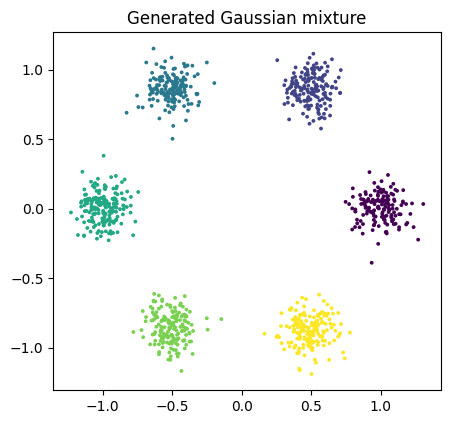

In [15]:
def get_hexagon_vertices(x=0, y=0, side=1):
    return [(x+side*np.cos(np.pi/3*i), y+side*np.sin(np.pi/3*i)) for i in range(6)]

def make_hexagon_gaussian_mixture(n_samples, noise=0.1):
    """
    Generate data from a mixture of 6 Gaussians.
    """
    hexagon_vertices = get_hexagon_vertices(x=0, y=0, side=1)
    X = []
    y = []
    for _ in range(n_samples):
        vertex_id = np.random.randint(6)
        X.append(np.random.normal(loc=hexagon_vertices[vertex_id], scale=0.1))
        y.append(vertex_id)
    X = np.array(X)
    y = np.array(y)
    return X, y

X_train_gm, y_train_gm = make_hexagon_gaussian_mixture(1000, noise=0.1)
X_test_gm, y_test_gm = make_hexagon_gaussian_mixture(300, noise=0.1)

fig, ax = plt.subplots(figsize=(5, 5))
ax.title.set_text("Generated Gaussian mixture")
ax.scatter(X_train_gm[:, 0], X_train_gm[:, 1], c=y_train_gm, s=3)
ax.set_aspect('equal')
plt.show()

<div style="color: green; font-weight:bold">
Same as in the correct solution. Colors are labels, which will be used later.
</div>

Epoch 0/1000: train_loss=0.5037, test_loss=0.5318
Epoch 101/1000: train_loss=-1.4053, test_loss=-1.0569
Epoch 202/1000: train_loss=-1.6158, test_loss=-1.2911
Epoch 303/1000: train_loss=-1.6412, test_loss=-1.4158
Epoch 404/1000: train_loss=-1.6724, test_loss=-1.4267
Epoch 505/1000: train_loss=-1.4974, test_loss=-1.3670
Epoch 606/1000: train_loss=-1.7123, test_loss=-1.4895
Epoch 707/1000: train_loss=-1.7546, test_loss=-1.4575
Epoch 808/1000: train_loss=-1.7350, test_loss=-1.4044
Epoch 909/1000: train_loss=-1.7760, test_loss=-1.4612
Epoch 1000/1000: train_loss=-1.7263, test_loss=-1.3880


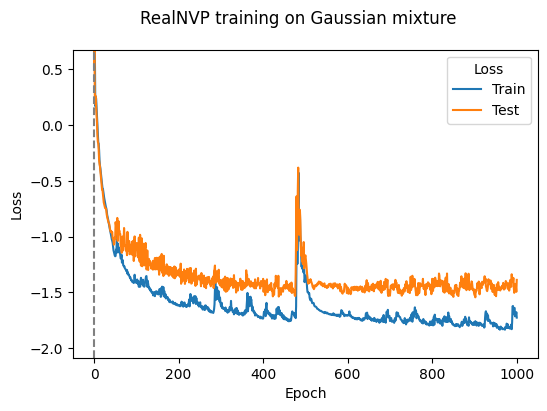

In [16]:
model_gm = RealNVP_1(2, 128, 8)
df = train_inn(model=model_gm, X_train=X_train_gm, X_test=X_test_gm, 
               n_epochs=1000, 
               batch_size=1000,
               learning_rate=0.001)

plot_training_losses(df, title="RealNVP training on Gaussian mixture", starting_epoch=0)

<div style="color: green; font-weight:bold">
Ok.
</div>

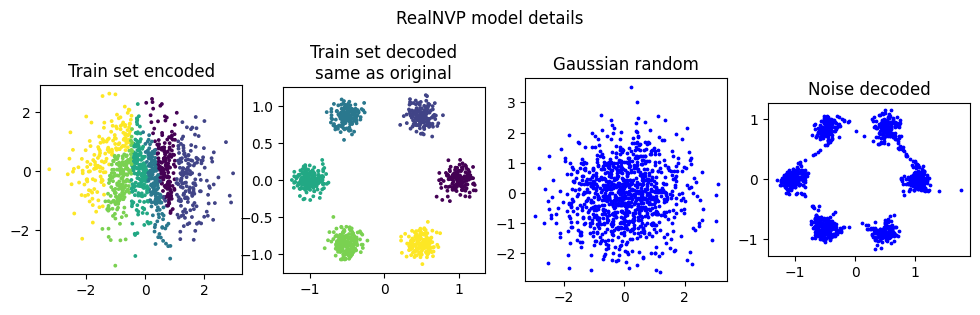

In [ ]:
plot_model_details(model_gm, X_train_gm, y_train_gm, title="RealNVP model details")

<div style="color: green; font-weight:bold">
Ok. Our solution has more plots and they are more informative. We still could add model details such as MMD or number of layers to plots title.
</div>

```
Comment: the results show that the model performed somehow on this task, however, 2 moons dataset was easier to learn.
```

<div style="color: green; font-weight:bold">
Essentially equivalent to the correct solution. Training more networks would be useful to compare different hyperparameters on this dataset.
</div>

## 2 Two moons with a conditional invertible neural network
The function sklearn.datasets.make_moons also returns a label for the moon where each data point belongs to, and your function to generate the GMM on the hexagon can easily be extended to do this as well. We can use this information to train a conditional RealNVP for the conditional distribution p(x | y) with y the label. Here, the nested networks receive a one-hot encoding of the label as an additional input for both the forward and reverse passes through the RealNVP. Extend the implementation from task 1 accordingly. The constructor needs a new argument condition_size, and the encoder and decoder functions must now accept a condition of appropriate size.

Make sure that the generalized design works in vectorized mode. Especially, the extended function RealNVP.sample(self, num_samples, conditions) should generate num_sample points for every row of condition.

In [17]:
class CouplingBlockConditional(nn.Module):
    def __init__(self, input_size, hidden_size, condition_size):
        super(CouplingBlockConditional, self).__init__()
        
        # d_tilde is size of what will be transformed
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.condition_size = condition_size
        self.d_tilde = input_size // 2
        

        # 2 hidden layers with ReLU activation and linear output layer. exp and tanh are applied later
        self.scale_network = nn.Sequential(
            nn.Linear(self.d_tilde + self.condition_size, self.hidden_size), # Added - condition y is also in input
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.d_tilde),
            nn.Tanh(),
        )
        
        # 2 hidden layers with ReLU activation and linear output layer
        self.translation_network = nn.Sequential(
            nn.Linear(self.d_tilde + self.condition_size, self.hidden_size), # Added - condition y is also in input
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.d_tilde),
        )

    def forward(self, x, y):
        x1 = x[:, :self.d_tilde]
        x2 = x[:, self.d_tilde:] 
        
        z1 = x1

        x1_y = torch.cat([x1, y], dim=1) # Added - conditional, concat y to x1

        s = self.scale_network(x1_y)
        t = self.translation_network(x1_y)
        z2 = torch.exp(torch.tanh(s)) * x2 + t

        z = torch.cat([z1, z2], dim=1)

        log_det_jacobian = torch.sum(torch.tanh(s), dim=1) 

        return z, log_det_jacobian
    
    def inverse(self, z, y):
        z1 = z[:, :self.d_tilde]
        z2 = z[:, self.d_tilde:]

        x1 = z1

        x1_y = torch.cat([z1, y], dim=1) # Added - conditional, concat y to x1
        s = self.scale_network(x1_y)
        t = self.translation_network(x1_y)

        x2 = (z2 - t) * torch.exp(-1 * torch.tanh(s)) 
              
        x = torch.cat([x1, x2], dim=1)

        return x

class RealNVP_2(nn.Module):
    def __init__(self, input_size, hidden_size, blocks, condition_size):
        super(RealNVP_2, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.blocks = blocks
        self.condition_size = condition_size

        self.layers = nn.ModuleList([CouplingBlockConditional(self.input_size, self.hidden_size, self.condition_size)
                                     for _ in range(self.blocks)])
        
        self.orthonormal_matrices = []
        self.orthonormal_matrices_T = []
        for i in range(self.blocks-1):
            matrix = self._get_orthonormal_matrix(self.input_size)
            self.orthonormal_matrices.append(matrix)
            self.orthonormal_matrices_T.append(torch.transpose(matrix, 0, 1)) # for inverse pass (decoder)

    def _get_orthonormal_matrix(self, size):
        Q, _ = torch.qr(torch.randn(size, size))
        return nn.Parameter(Q, requires_grad=False)
        
    def encoder(self, x, y_onehotencoded_conditions):
        log_det_jacobian_sum = 0
        for i in range(self.blocks):
            x, log_det_jacobian = self.layers[i](x, y_onehotencoded_conditions)
            log_det_jacobian_sum += log_det_jacobian
            if i < self.blocks - 1:
                x = torch.matmul(x, self.orthonormal_matrices[i])
        return x, log_det_jacobian_sum
    
    def decoder(self, z, y_onehotencoded_conditions):
        for i in range(self.blocks - 1, -1, -1):
            if i < self.blocks - 1:
                z = torch.matmul(z, self.orthonormal_matrices_T[i]) # use transposed orthonormal matrix to undo it's effect
            z = self.layers[i].inverse(z, y_onehotencoded_conditions)
        return z

    def forward(self, x, y_onehotencoded_conditions):
        z, log_det_jacobian_sum = self.encoder(x, y_onehotencoded_conditions)
        return z, log_det_jacobian_sum
    
    def sample(self, num_samples, conditions):
        conditions = torch.from_numpy(conditions).float()
        outputs = []
        for y_onehotencoded_condition in conditions:
            z = torch.randn(num_samples, self.input_size)
            y_repeated = y_onehotencoded_condition.repeat(num_samples, 1)
            samples = self.decoder(z, y_repeated)
            outputs.append(samples)
        outputs = torch.cat(outputs, dim=0)
        return outputs

<div style="color: green; font-weight:bold">
Same comments as to the implementation from task 1 apply here.
<br><br>
Changes of the implementation here vs in task 1 are the same as in the correct solution. Our solution here is basically the same as the correct one.

The correct solution uses a handy function torch.nn.functional.one_hot. Our solution one-hot-encodes manually later which longer and harder.
</div>

In [18]:
# training function updated for condition y

def train_inn_conditional(model, X_train, X_test, y_train, y_test, n_epochs, batch_size, learning_rate=0.001, size_of_the_training_set=-1, loss_function=custom_negative_log_likelihood_loss):
    """
    Args:
        model (nn.Module): a RealNVP model which returns z and log_det_jacobian_sum
        X_train (np.ndarray): the training data
        X_test (np.ndarray): the test data
        y_train (np.ndarray): the training data conditions
        y_test (np.ndarray): the test data conditions
        n_epochs (int): the number of training epochs
        batch_size (int): the batch size
        learning_rate (float): the learning rate
        size_of_the_training_set (int): subset of the training set to use (default: -1, i.e. use the whole training set)
        loss_function (function): the loss function to use (default: custom_negative_log_likelihood_loss)
    """
    criterion = loss_function
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    test_losses = []

    X_train = X_train[:size_of_the_training_set]
    y_train = y_train[:size_of_the_training_set]
    
    data_train = torch.from_numpy(X_train).float()
    y_train = torch.from_numpy(y_train).float()
    y_onehotencoded_conditions_train = torch.eye(model.condition_size)[y_train.long()].float() # Added - one-hot encode y
    data_test = torch.from_numpy(X_test).float()
    y_test = torch.from_numpy(y_test).float()
    y_onehotencoded_conditions_test = torch.eye(model.condition_size)[y_test.long()].float() # Added - one-hot encode y

    # loss before training
    with torch.no_grad():
        z, log_det_jacobian_sum = model(data_train, y_onehotencoded_conditions_train)
        loss = criterion(z, log_det_jacobian_sum)
        train_losses.append(loss.item())
        z, log_det_jacobian_sum = model(data_test, y_onehotencoded_conditions_test)
        loss = criterion(z, log_det_jacobian_sum)
        test_losses.append(loss.item())
    print(f"Epoch 0/{n_epochs}: train_loss={train_losses[-1]:.4f}, test_loss={test_losses[-1]:.4f}")

    # trainning
    for epoch in range(n_epochs):
        train_loss = 0
        test_loss = 0
        for i in range(0, len(X_train), batch_size):
            data = data_train[i:i+batch_size]
            y_data = y_onehotencoded_conditions_train[i:i+batch_size] # Added - one-hot encoded y
            optimizer.zero_grad()
            z, log_det_jacobian_sum = model(data, y_data)
            loss = criterion(z, log_det_jacobian_sum)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * len(data)
        train_loss /= len(X_train)
        train_losses.append(train_loss)

        with torch.no_grad():
            for i in range(0, len(X_test), batch_size):
                data = data_test[i:i+batch_size]
                y_data = y_onehotencoded_conditions_test[i:i+batch_size] # Added - one-hot encoded y
                z, log_det_jacobian_sum = model(data, y_data)
                loss = criterion(z, log_det_jacobian_sum)
                test_loss += loss.item() * len(data)
            test_loss /= len(X_test)
            test_losses.append(test_loss)
            
        if (epoch+1) % (n_epochs//10+1) == 0 or epoch == n_epochs-1:
            print(f"Epoch {epoch+1}/{n_epochs}: train_loss={train_loss:.4f}, test_loss={test_loss:.4f}")
    df = pd.DataFrame({'train': train_losses, 'test': test_losses, 'epoch': list(range(n_epochs+1))})
    return df

<div style="color: green; font-weight:bold">
Essentially equal.
</div>

In [19]:
def plot_model_details_conditional(model, X_train, y_train, title="Model details"):
    y_onehotencoded_conditions = torch.eye(model.condition_size)[torch.from_numpy(y_train).long()].float() # Added - one-hot encode y
    with torch.no_grad():
        Z_train = model(torch.from_numpy(X_train).float(), y_onehotencoded_conditions)[0]
        X_decoded = model.decoder(Z_train, y_onehotencoded_conditions)
        Z_train = Z_train.detach().numpy()

        Z_noise = torch.randn((1000, X_train.shape[1]))
        y_rand = torch.randint(0, model.condition_size, (1000,))
        y_onehotencoded_conditions_rand = torch.eye(model.condition_size)[y_rand.long()].float() # Added - one-hot encode y
        X_noise = model.decoder(Z_noise, y_onehotencoded_conditions_rand).detach().numpy()

    fig, axs = plt.subplots(1, 4, figsize=(12, 4))
    fig.suptitle(title, y=0.92)
    axs[0].scatter(Z_train[:, 0], Z_train[:, 1], c=y_train, s=3)
    axs[0].set_title("Train set encoded")
    axs[0].set_aspect('equal')
    axs[1].scatter(X_decoded[:, 0], X_decoded[:, 1], c=y_train, s=3)
    axs[1].set_title("Train set decoded\nsame as original")
    axs[1].set_aspect('equal')
    axs[2].scatter(Z_noise[:, 0], Z_noise[:, 1], c=y_rand, s=3)
    axs[2].set_title("Gaussian random")
    axs[2].set_aspect('equal')
    axs[3].scatter(X_noise[:, 0], X_noise[:, 1], c=y_rand, s=3)
    axs[3].set_title("Noise decoded")
    axs[3].set_aspect('equal')
    plt.show()   

<div style="color: green; font-weight:bold">
Ok.
</div>

Now, train the conditional INN with the labels from the two moons and the GMM. 

In [20]:
X_train, y_train, X_test, y_test = get_moons_data(1000, 200, noise=0.1)

<div style="color: green; font-weight:bold">
Ok.
</div>

In [21]:
model = RealNVP_2(input_size=2, hidden_size=128, blocks=8, condition_size=2)
df = train_inn_conditional(model=model, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test,
               n_epochs=100, 
               batch_size=1000,
               learning_rate=0.001)

/tmp/ipykernel_44/3709814383.py:84: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2497.)
  Q, _ = torch.qr(torch.randn(size, size))
Epoch 0/100: train_loss=0.6358, test_loss=0.6326
Epoch 11/100: train_loss=-0.7846, test_loss=-0.7908
Epoch 22/100: train_loss=-1.2279, test_loss=-1.2360
Epoch 33/100: train_loss=-1.4569, test_loss=-1.3197
Epoch 44/100: train_loss=-1.5150, test_loss=-1.4720
Epoch 55/100: train_loss=-1.5609, test_loss=-1.4708
Epoch 66/100: train_loss=-1.5747, test_loss=-1.4717
Epoch 77/100: train_loss=-1.5820, test_loss=-1.4783
Epoch 88/100: train_loss=-1.5934, test_loss=-1.4730
Epoch 99/100: train_loss=-1.5962, test_loss=-1.4687
Epoch 100/100: train_l

<div style="color: green; font-weight:bold">
Ok. As the depreciation warning says, we should update the way we do the QR decomposition to make orthogonal matrices.
</div>

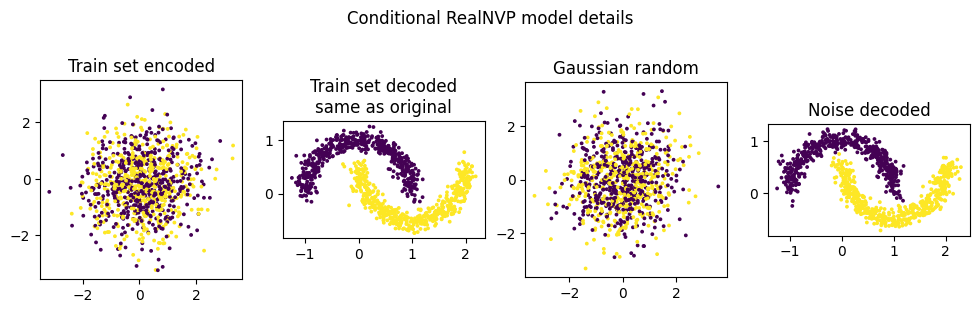

In [ ]:
plot_model_details_conditional(model, X_train, y_train, title="Conditional RealNVP model details")

<div style="color: green; font-weight:bold">
Ok.
</div>

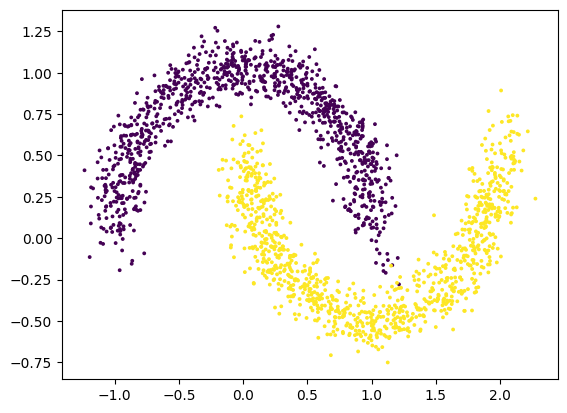

In [ ]:
N = 1000
conditions_values = np.array([0, 1])
conditions_onehotencoded = np.eye(2)[conditions_values]

# proof that method 'sample' works 
X_sampled = model.sample(num_samples=N, conditions=conditions_onehotencoded).detach().numpy()

conditions_values_repeated = np.repeat(conditions_values, N)
plt.scatter(X_sampled[:, 0], X_sampled[:, 1], s=3, c=conditions_values_repeated)
plt.show()

<div style="color: green; font-weight:bold">
Ok.
</div>

In [43]:
#GM
model_gm_task2 = RealNVP_2(input_size=2, hidden_size=128, blocks=8, condition_size=6)
df_gm = train_inn_conditional(model=model_gm_task2, X_train=X_train_gm, X_test=X_test_gm, y_train=y_train_gm, y_test=y_test_gm,
               n_epochs=100, 
               batch_size=1000,
               learning_rate=0.001)

Epoch 0/100: train_loss=0.5667, test_loss=0.5828
Epoch 11/100: train_loss=-1.9305, test_loss=-2.1142
Epoch 22/100: train_loss=-3.3445, test_loss=-3.2953
Epoch 33/100: train_loss=-3.5241, test_loss=-3.3812
Epoch 44/100: train_loss=-3.5977, test_loss=-3.4804
Epoch 55/100: train_loss=-3.6113, test_loss=-3.4791
Epoch 66/100: train_loss=-3.6211, test_loss=-3.4672
Epoch 77/100: train_loss=-3.6212, test_loss=-3.4658
Epoch 88/100: train_loss=-3.6336, test_loss=-3.4611
Epoch 99/100: train_loss=-3.6389, test_loss=-3.4467
Epoch 100/100: train_loss=-3.6387, test_loss=-3.4554


<div style="color: green; font-weight:bold">
Ok.
</div>

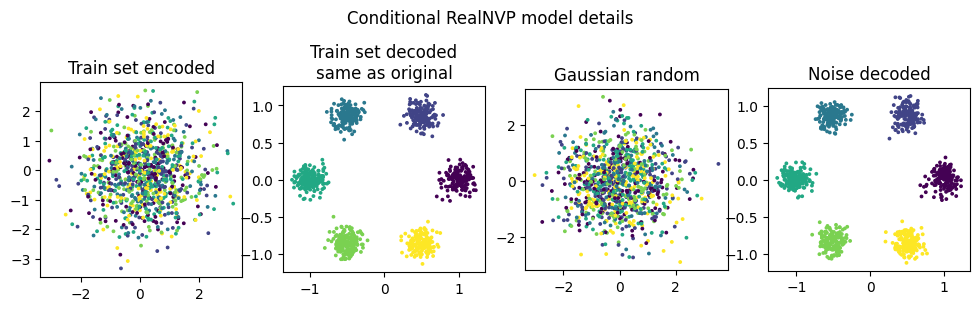

In [ ]:
plot_model_details_conditional(model_gm, X_train_gm, y_train_gm, title="Conditional RealNVP model details")

<div style="color: green; font-weight:bold">
Ok. A comment would be useful here.
</div>

In addition, train for the GMM with only two labels, such that two peaks get label 0, and the other four are label 1 (you can imagine that two peaks are red, and the others are green). 

In [38]:
import copy
y_train_gm2=copy.deepcopy(y_train_gm)
y_test_gm2=copy.deepcopy(y_test_gm)

#change 2 into 0
y_train_gm2[y_train_gm2==2]=0
y_test_gm2[y_test_gm2==2]=0
#change 5,3,4 into 1
y_train_gm2[y_train_gm2==5]=1
y_train_gm2[y_train_gm2==3]=1
y_train_gm2[y_train_gm2==4]=1

y_test_gm2[y_test_gm2==5]=1
y_test_gm2[y_test_gm2==3]=1
y_test_gm2[y_test_gm2==4]=1
#GM
model_gm2 = RealNVP_2(input_size=2, hidden_size=128, blocks=8, condition_size=2)
df_gm2 = train_inn_conditional(model=model_gm2, X_train=X_train_gm, X_test=X_test_gm, y_train=y_train_gm2, y_test=y_test_gm2,
               n_epochs=100, 
               batch_size=1000,
               learning_rate=0.001)

Epoch 0/100: train_loss=0.4067, test_loss=0.4033
Epoch 11/100: train_loss=-0.9952, test_loss=-1.0048
Epoch 22/100: train_loss=-1.6528, test_loss=-1.5890
Epoch 33/100: train_loss=-1.9282, test_loss=-1.7480
Epoch 44/100: train_loss=-2.0740, test_loss=-1.9075
Epoch 55/100: train_loss=-2.1691, test_loss=-1.9674
Epoch 66/100: train_loss=-2.2034, test_loss=-1.9505
Epoch 77/100: train_loss=-2.2485, test_loss=-2.0517
Epoch 88/100: train_loss=-2.3077, test_loss=-2.0447
Epoch 99/100: train_loss=-2.3300, test_loss=-2.0164
Epoch 100/100: train_loss=-2.3291, test_loss=-2.1005


<div style="color: green; font-weight:bold">
Ok. Our solution marked different 2 clusters of points to the same class, but the results are comparable.
</div>

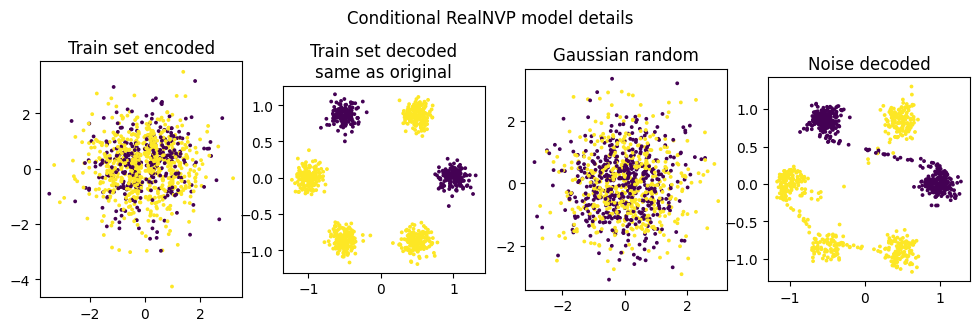

In [39]:
plot_model_details_conditional(model_gm2, X_train_gm, y_train_gm2, title="Conditional RealNVP model details")

<div style="color: green; font-weight:bold">
Ok.
</div>

Evaluate your networks first in conditional mode p(x | y), i.e. by evaluating for one label at a time, and compare with test data from the true conditional distributions.

In [44]:
import copy
#evaluate network in conditional mode p(x|y)
def evaluate_conditional_mode(model, X_test, y_test, which_label=0):
    y_test_class_3=copy.deepcopy(y_test)
    X_test_class_3=copy.deepcopy(X_test)
    mask=(y_test_class_3==which_label)
    y_test_class_3=y_test_class_3[mask]
    X_test_class_3=X_test_class_3[mask]
    
    conditions_values = np.zeros(len(set(y_test)))
    conditions_values[which_label]=1
    conditions_all=np.array(conditions_values)
    conditions_all=conditions_all.reshape(-1,len(set(y_test)))

    X_sampled = model.sample(num_samples=len(X_test_class_3), conditions=conditions_all).detach().numpy()
    mmd_of_label=mmd(X_test_class_3, X_sampled, 0.5)

    return mmd_of_label, X_sampled


<div style="color: green; font-weight:bold">
Ok.
</div>

Two moons dataset

In [27]:
mmd0_2m, samples0_2m = evaluate_conditional_mode(model, X_test, y_test, which_label=0)
mmd1_2m, samples1_2m = evaluate_conditional_mode(model, X_test, y_test, which_label=1)

In [28]:
print(f"MMD for class 0: {mmd0_2m}.")
print(f"MMD for class 1: {mmd1_2m}.")

MMD for class 0: 0.02603227236047967.
MMD for class 1: 0.01631813669314708.


<div style="color: green; font-weight:bold">
Ok. Correct solution put MMD in plot titles which made the result more concise.
</div>

GMM

In [45]:
mmd0, samples0 = evaluate_conditional_mode(model_gm_task2, X_test_gm, y_test_gm, which_label=0)
mmd1, samples1 = evaluate_conditional_mode(model_gm_task2, X_test_gm, y_test_gm, which_label=1)
mmd2, samples2 = evaluate_conditional_mode(model_gm_task2, X_test_gm, y_test_gm, which_label=2)
mmd3, samples3 = evaluate_conditional_mode(model_gm_task2, X_test_gm, y_test_gm, which_label=3)
mmd4, samples4 = evaluate_conditional_mode(model_gm_task2, X_test_gm, y_test_gm, which_label=4)
mmd5, samples5 = evaluate_conditional_mode(model_gm_task2, X_test_gm, y_test_gm, which_label=5)

<div style="color: green; font-weight:bold">
Ok. Could be more concise with a loop.
</div>

In [46]:
print(f"MMD for class 0: {mmd0}.")
print(f"MMD for class 1: {mmd1}.")
print(f"MMD for class 2: {mmd2}.")
print(f"MMD for class 3: {mmd3}.")
print(f"MMD for class 4: {mmd4}.")
print(f"MMD for class 5: {mmd5}.")

MMD for class 0: 0.03724761389226239.
MMD for class 1: 0.04878481357050246.
MMD for class 2: 0.046221082682756265.
MMD for class 3: 0.04133335412241901.
MMD for class 4: 0.03947017365900951.
MMD for class 5: 0.03745085570145856.


<div style="color: green; font-weight:bold">
Ok. Not present in the correct solution but required by the task description.
</div>

Then, merge synthetic data from all labels and compare the marginal distributions p(x). Is the quality of the conditional INN better or worse than the plain INN from task 1?

Two moons

In [32]:
model_2m_1 = RealNVP_1(2, 128, 8)
df = train_inn(model=model_2m_1, X_train=X_train, X_test=X_test, 
            n_epochs=200, 
            batch_size=1000,
            learning_rate=0.001)

Epoch 0/200: train_loss=1.1570, test_loss=1.1581
Epoch 21/200: train_loss=-0.3449, test_loss=-0.3663
Epoch 42/200: train_loss=-0.5312, test_loss=-0.5277
Epoch 63/200: train_loss=-0.6753, test_loss=-0.5934
Epoch 84/200: train_loss=-0.7436, test_loss=-0.6842
Epoch 105/200: train_loss=-0.7880, test_loss=-0.6685
Epoch 126/200: train_loss=-0.8020, test_loss=-0.7200
Epoch 147/200: train_loss=-0.8123, test_loss=-0.7013
Epoch 168/200: train_loss=-0.8174, test_loss=-0.7114
Epoch 189/200: train_loss=-0.8491, test_loss=-0.7191
Epoch 200/200: train_loss=-0.8475, test_loss=-0.7056


<div style="color: green; font-weight:bold">
Ok.
</div>

In [33]:
#Two moons
samplesmerged_2m=np.concatenate([samples0_2m, samples1_2m])

N = 300
X_sampled_2m = model_2m_1.sample(num_samples=N).detach().numpy()

mmd(samplesmerged_2m, X_sampled_2m, 0.5)

0.006982103128741479

<div style="color: green; font-weight:bold">
Ok. A comment would be useful.
</div>

In [34]:
labels0_2m = np.zeros(len(samples0_2m))
labels1_2m = np.ones(len(samples1_2m))
samples_labels_2m=np.concatenate([labels0_2m, labels1_2m])

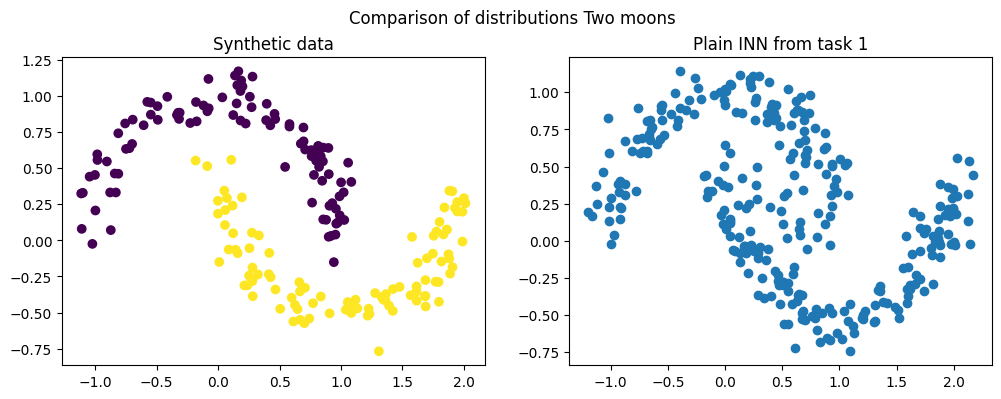

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle("Comparison of distributions Two moons", y=1)
axs[0].scatter(samplesmerged_2m[:,0], samplesmerged_2m[:,1], c=samples_labels_2m)
axs[0].set_title("Synthetic data")
axs[1].scatter(X_sampled_2m[:,0], X_sampled_2m[:,1])
axs[1].set_title("Plain INN from task 1")
plt.show()

<div style="color: green; font-weight:bold">
Ok. Plot not present in the correct solution.
</div>

GMM

In [47]:
samplesmerged=np.concatenate([samples0, samples1, samples2, samples3, samples4, samples5])

N = 300
X_sampled = model_gm.sample(num_samples=N).detach().numpy()

mmd(samplesmerged, X_sampled, 0.5)

0.01011403224492835

<div style="color: green; font-weight:bold">
Ok. A comment what the number is would be useful.
</div>

In [48]:
labels0 = np.zeros(len(samples0))
labels1 = np.ones(len(samples1))
labels2 = 2* np.ones(len(samples2))
labels3 = 3*np.ones(len(samples3))
labels4 = 4*np.ones(len(samples4))
labels5 = 5*np.ones(len(samples5))
samples_labels=np.concatenate([labels0, labels1, labels2, labels3, labels4, labels5])

<div style="color: green; font-weight:bold">
Ok.
</div>

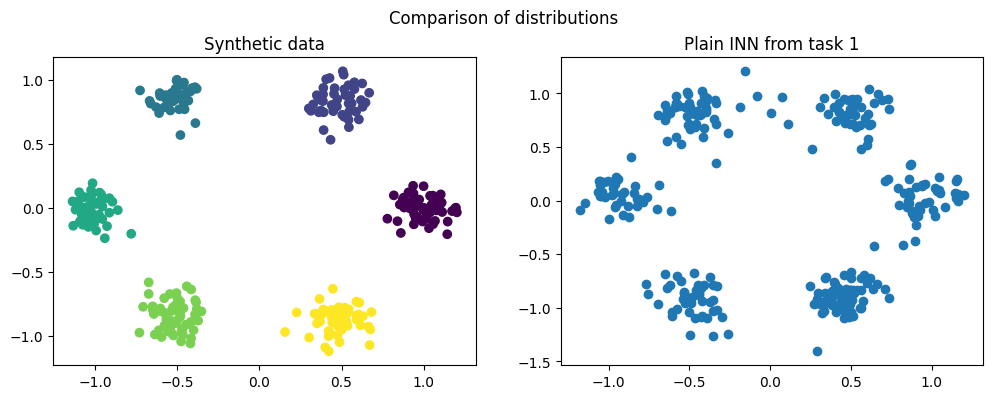

In [49]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle("Comparison of distributions", y=1)
axs[0].scatter(samplesmerged[:,0], samplesmerged[:,1], c=samples_labels)
axs[0].set_title("Synthetic data")
axs[1].scatter(X_sampled[:,0], X_sampled[:,1])
axs[1].set_title("Plain INN from task 1")
plt.show()

<div style="color: green; font-weight:bold">
Ok. Plot similar to one in the correct solution.
</div>

```
Comment: The quality of the conditional INN seems to be better than the one from task 1.
```

## 3 Higher-dimensional data with an INN
1. Repeat task 1 with the digits dataset (sklearn.datasets.load_digits()). Since these images have size 8 × 8, the codes will be 64-dimensional. Plot various 2D projections of the code space distribution for test data and check if the codes are indeed standard normally distributed.

In [55]:
def get_digits_data():
    digits = load_digits()
    X = digits.data
    y = digits.target
    return X, y

X, y = get_digits_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1617, 64), (1617,), (180, 64), (180,))

<div style="color: green; font-weight:bold">
Ok.
</div>

In [56]:
# function that plots 4 plots, see usage below after model training

def plot_model_details_pca(model, X_train, y_train, X_test, y_test, title="Some model"):
    with torch.no_grad():
        Z_train = model(torch.from_numpy(X_train).float())[0]
        X_decoded = model.decoder(Z_train).detach().numpy()
        Z_train = Z_train.detach().numpy()
        Z_train_pca = PCA(n_components=2).fit_transform(Z_train) # Added - PCA
        Z_noise = torch.randn((1000, X_train.shape[1]))
        X_noise = model.decoder(Z_noise).detach().numpy()
        Z_test = model(torch.from_numpy(X_test).float())[0].detach().numpy()
        Z_test_pca = PCA(n_components=2).fit_transform(Z_test)

    # scatterplot codes z_train
    fig, ax = plt.subplots(1, 1, figsize=(3,3))
    ax.scatter(Z_train_pca[:, 0], Z_train_pca[:, 1], c=y_train, s=3)
    ax.set_title("Train set encoded (PCA)")
    ax.set_aspect('equal')
    plt.show()

    # show digits after reconstruction
    fig, axs = plt.subplots(2, 10, figsize=(12, 3))
    fig.suptitle(f"{title}\nTrain set decoded", y=1, fontsize=16)
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    # choose random len(axs.flat) rows of X_decoded
    X_decoded_sample = X_decoded[np.random.choice(len(X_decoded), size=len(axs.flat), replace=False)].copy()
    X_decoded_sample[X_decoded_sample < 0] = 0
    X_decoded_sample[X_decoded_sample > 16] = 16
    for i, axi in enumerate(axs.flat):
        im = axi.imshow(X_decoded_sample[i].reshape(8, 8), cmap="gray")
        im.set_clim(0, 16)
        axi.axis("off")
    plt.show()

    # scatterplot codes z_noise
    fig, ax = plt.subplots(1, 1, figsize=(3,3))
    ax.scatter(Z_test_pca[:, 0], Z_test_pca[:, 1], c=y_test, s=3)
    ax.set_title(f"{title}\nTest set codes (PCA)")
    ax.set_aspect('equal')
    plt.show()

    # show digits from random noise
    fig, axs = plt.subplots(2, 10, figsize=(12, 3))
    fig.suptitle(f"{title}\nNoise decoded", y=1, fontsize=16)
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    # choose random len(axs.flat) rows of X_noise
    X_noise_sample = X_noise[np.random.choice(len(X_noise), size=len(axs.flat), replace=False)].copy()
    X_noise_sample[X_noise_sample < 0] = 0
    X_noise_sample[X_noise_sample > 16] = 16
    for i, axi in enumerate(axs.flat):
        im = axi.imshow(X_noise_sample[i].reshape(8, 8), cmap="gray")
        im.set_clim(0, 16)
        axi.axis("off")
    plt.show()

<div style="color: green; font-weight:bold">
Ok. A bit long for a simple function making some plots.
</div>

Now generate data with your model. You will probably notice that the quality is not as good as what you got from an autoencoder in exercise 02. This is likely due to the fact that the dataset is too small to fully train a 64-dimensional code space. Recall, thet the code space in exercise 02 was at most 8-dimensional.

In [57]:
# a sample model
model = RealNVP_1(64, 128, 8)
df = train_inn(model=model, X_train=X_train, X_test=X_test, 
               n_epochs=100, 
               batch_size=64,
               learning_rate=0.001)

Epoch 0/100: train_loss=24618.3945, test_loss=22915.3594
Epoch 11/100: train_loss=73.6635, test_loss=78.3523
Epoch 22/100: train_loss=56.5957, test_loss=69.3967
Epoch 33/100: train_loss=50.4084, test_loss=68.4508
Epoch 44/100: train_loss=44.1817, test_loss=72.2433
Epoch 55/100: train_loss=39.5345, test_loss=73.7289
Epoch 66/100: train_loss=36.0598, test_loss=74.2611
Epoch 77/100: train_loss=33.9689, test_loss=85.6857
Epoch 88/100: train_loss=32.1855, test_loss=78.3420
Epoch 99/100: train_loss=30.2581, test_loss=85.5976
Epoch 100/100: train_loss=31.0577, test_loss=85.1228


<div style="color: green; font-weight:bold">
Ok.
</div>

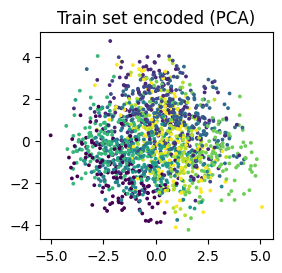

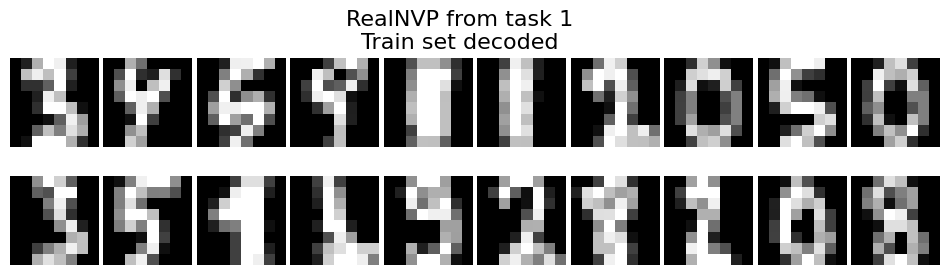

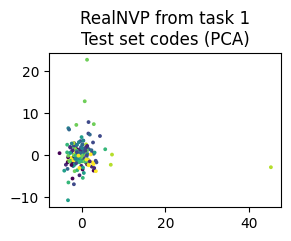

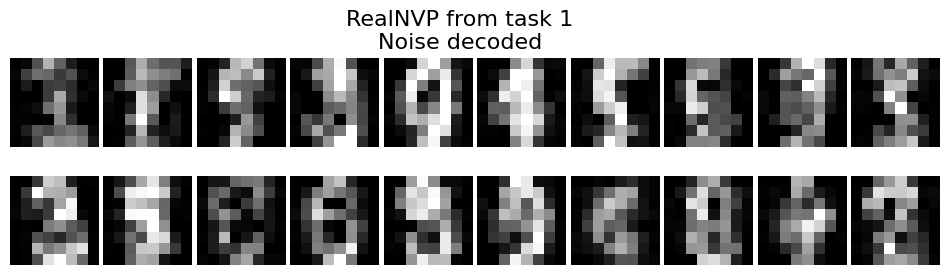

In [58]:
plot_model_details_pca(model, X_train, y_train, X_test, y_test, title="RealNVP from task 1")

<div style="color: green; font-weight:bold">
Ok. We used PCA as a projection of codes dimension which is different from simply viewing random 2 dimensions as in the correct solution. 

Our results are similar to those obtained in the correct solution.
</div>

```
Comment: Codes are correctly distributed as standard normal. A few points after encoding test set are far from the center. However, note, that we used PCA with only 2 components to inspect the 64-dimensional distribution of codes.

We present the codes of training set and how they are decoded back to the original, clearly readable dataset.

Generated data is of poor quality, and sometimes is not readable at all.
```

<div style="color: green; font-weight:bold">
We did not add MMD, which would be useful to make a quantitative comparison between generated and original data.
</div>

2. To reduce this problem, we can introduce an artifficial bottleneck: In addition to the NLL loss, we also minimize a reconstruction loss. For this to make sense in the presence of perfect reconstruction, we decode the data only from the first k code dimensions (with k a hyperparameter, e.g. k = 2, 4, 8). The remaining code dimensions are set to zero before decoding and calculating the reconstruction loss (but not for the calculation of the NLL loss). This trick ensures that the important information about reconstruction must be encoded in the first k dimensions, like in a standard autoencoder. The remaining 64 − k code dimensions should contain the less important details.

In [59]:
# training function with added artificial bottleneck and reconstruction loss

def custom_negative_log_likelihood_loss(model_outputs, log_det_jacobian_sum):
    return torch.mean(torch.sum(0.5 * torch.pow(model_outputs, 2), dim=1) - log_det_jacobian_sum)

def custom_reconstruction_loss(model_outputs, original_data):
    return torch.mean(torch.sum(torch.pow(model_outputs - original_data, 2), dim=1))

def train_inn_bottleneck(model, X_train, X_test, n_epochs, batch_size, learning_rate=0.001, size_of_the_training_set=-1, 
              nnl_loss_func=custom_negative_log_likelihood_loss, 
              reconstruction_loss_func=custom_reconstruction_loss, bottleneck_size=8, # Added - bottleneck and reconstruction loss
              reconstruction_loss_weight=1.0): # Added - weight of reconstruction loss
    """
    Args:
        model (nn.Module): a RealNVP model which returns z and log_det_jacobian_sum
        X_train (np.ndarray): the training data
        X_test (np.ndarray): the test data
        n_epochs (int): the number of training epochs
        batch_size (int): the batch size
        learning_rate (float): the learning rate
        size_of_the_training_set (int): subset of the training set to use (default: -1, i.e. use the whole training set)
        nnl_loss_func (function): the negative log likelihood loss function to use (default: custom_negative_log_likelihood_loss)
    # Added - bottleneck and reconstruction loss
        reconstruction_loss_func (function): the reconstruction loss function to use (default: custom_reconstruction_loss)
        bottleneck_size (int): the size of the bottleneck (default: 2)
        reconstruction_loss_weight (float): the weight of the reconstruction loss (default: 1.0)
    """

    # Added - function to compute (weighted) sum of nll and reconstruction loss that adds bottleneck
    def compute_loss_with_bottleneck(model, X,
                                     nnl_loss_func=nnl_loss_func,
                                     reconstruction_loss_func=reconstruction_loss_func,
                                     bottleneck_size=bottleneck_size,
                                     reconstruction_loss_weight=reconstruction_loss_weight):
        z, log_det_jacobian_sum = model(X)
        nll_loss = nnl_loss_func(z, log_det_jacobian_sum)
        ## Added part - mask bottlenecked part of z, reconstruct, get reconstruction loss and add to nll loss
        z_bottlenecked = torch.zeros_like(z)
        z_bottlenecked[:, :bottleneck_size] = z[:, :bottleneck_size].clone()
        X_reconstructed = model.decoder(z_bottlenecked)
        reconstruction_loss = reconstruction_loss_func(X_reconstructed, X)
        loss = nll_loss + reconstruction_loss_weight * reconstruction_loss
        return loss, (nll_loss, reconstruction_loss)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    test_losses = []

    X_train = X_train[:size_of_the_training_set]
    
    data_train = torch.from_numpy(X_train).float()
    data_test = torch.from_numpy(X_test).float()

    # loss before training
    with torch.no_grad():
        loss, (nll_loss_train, reconstruction_loss_train) = compute_loss_with_bottleneck(model, data_train)
        train_losses.append(loss.item())
        loss, (nll_loss_test, reconstruction_loss_test) = compute_loss_with_bottleneck(model, data_test)
        test_losses.append(loss.item())
    print(f"Epoch 0/{n_epochs}: train_loss={train_losses[-1]:.4f}, test_loss={test_losses[-1]:.4f}")
    print(f"\tTrain: nll_loss={nll_loss_train:.4f}, reconstruction_loss={reconstruction_loss_train:.4f}")
    print(f"\tTest: nll_loss={nll_loss_test:.4f}, reconstruction_loss={reconstruction_loss_test:.4f}")

    # trainning
    for epoch in range(n_epochs):
        train_loss = 0
        train_nll_loss, train_reconstruction_loss = 0, 0
        test_loss = 0
        test_nll_loss, test_reconstruction_loss = 0, 0
        for i in range(0, len(X_train), batch_size):
            data = data_train[i:i+batch_size]
            optimizer.zero_grad()
            loss, (nll_loss, reconstruction_loss) = compute_loss_with_bottleneck(model, data)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * len(data)
            train_nll_loss += nll_loss.item() * len(data)
            train_reconstruction_loss += reconstruction_loss.item() * len(data)
        train_loss /= len(X_train)
        train_losses.append(train_loss)
        train_nll_loss /= len(X_train)
        train_reconstruction_loss /= len(X_train)

        with torch.no_grad():
            for i in range(0, len(X_test), batch_size):
                data = data_test[i:i+batch_size]
                loss, (nll_loss, reconstruction_loss) = compute_loss_with_bottleneck(model, data)
                test_loss += loss.item() * len(data)
                test_nll_loss += nll_loss.item() * len(data)
                test_reconstruction_loss += reconstruction_loss.item() * len(data)
            test_loss /= len(X_test)
            test_losses.append(test_loss)
            test_nll_loss /= len(X_test)
            test_reconstruction_loss /= len(X_test)
            
        if (epoch+1) % (n_epochs//10+1) == 0 or epoch == n_epochs-1:
            print(f"Epoch {epoch+1}/{n_epochs}: train_loss={train_loss:.4f}, test_loss={test_loss:.4f}")
            print(f"\tTrain: nll_loss={train_nll_loss:.4f}, reconstruction_loss={train_reconstruction_loss:.4f}")
            print(f"\tTest: nll_loss={test_nll_loss:.4f}, reconstruction_loss={test_reconstruction_loss:.4f}")
    df = pd.DataFrame({'train': train_losses, 'test': test_losses, 'epoch': list(range(n_epochs+1))})
    return df

<div style="color: green; font-weight:bold">
Differs but is a valid alternative:

- We reuse the model from task 1. In training, after computing NLL loss, we mask part of codes and ask the model to decode them. This is different from the correct solution, where the model is redefined to have this masking built-in into inverse (decoder) method. Our implementation is a valid alternative for training, and allows for easy experiments later, but the correct solution is more elegant as they also added if statement to sampling method.
- Also, we believe our training loop is more efficient because we do not load the digits dataset at each epoch. We load it once and then use it in a loop.

Rest is the same as in the correct solution.
</div>

In [60]:
def plot_model_details_bottleneck(model, X_train, bottleneck_size):
    data_shape = X_train.shape[1]
    with torch.no_grad():
        Z_random_masked_unimportant = torch.zeros((1000, data_shape))
        Z_random_masked_unimportant[:, :bottleneck_size] =  torch.randn((1000, bottleneck_size))
        X_masked_unimportant = model.decoder(Z_random_masked_unimportant).detach().numpy()

    # plot rows of digits with masked unimportant 
    fig, axs = plt.subplots(9, 20, figsize=(12, 6))
    fig.suptitle(f"Masked unimportant part of z, bottleneck={bottleneck_size}\nImages should be some numbers", y=1, fontsize=16)
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    # choose random len(axs.flat) rows of X_masked_unimportant
    X_masked_unimportant_sample = X_masked_unimportant[np.random.choice(len(X_masked_unimportant), size=len(axs.flat), replace=False)].copy()
    X_masked_unimportant_sample[X_masked_unimportant_sample < 0] = 0
    X_masked_unimportant_sample[X_masked_unimportant_sample > 16] = 16
    for i, axi in enumerate(axs.flat):
        im = axi.imshow(X_masked_unimportant_sample[i].reshape(8, 8), cmap="gray")
        im.set_clim(0, 16)
        axi.axis("off")
    plt.show()

    # plot rows of digits with fixed important
    fig, axs = plt.subplots(9, 20, figsize=(12, 6))
    fig.suptitle(f"Fixed important part of z, bottleneck={bottleneck_size}\nImages in each row should be variations of the same image", y=1, fontsize=16)
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for ax_row in axs:
        with torch.no_grad():
            Z_random_fixed_important = torch.randn((1000, data_shape))
            fixed_part = torch.randn((1000, bottleneck_size))
            Z_random_fixed_important[:, :bottleneck_size] = fixed_part
            X_fixed_important = model.decoder(Z_random_fixed_important).detach().numpy()

        # choose random len(axs.flat) rows of X_fixed_important
        X_fixed_important_sample = X_fixed_important[np.random.choice(len(X_fixed_important), size=len(axs.flat), replace=False)].copy()
        X_fixed_important_sample[X_fixed_important_sample < 0] = 0
        X_fixed_important_sample[X_fixed_important_sample > 16] = 16
        for i, axi in enumerate(ax_row):
            im = axi.imshow(X_fixed_important_sample[i].reshape(8, 8), cmap="gray")
            im.set_clim(0, 16)
            axi.axis("off")
    plt.show()

<div style="color: green; font-weight:bold">
Ok.
</div>

In [61]:
# Hard to train, did not really work out as expected after trying various sets of hyperparameters
model = RealNVP_1(64, 128, 4)
df = train_inn_bottleneck(model=model, X_train=X_train, X_test=X_test, 
               n_epochs=1000, 
               batch_size=64,
               bottleneck_size=8, 
               reconstruction_loss_weight=1,
               learning_rate=0.001)
# 64, 128, 4; 1000, 64, 8, 1 -> 13min, train nll 31, rec err 45,  

Epoch 0/1000: train_loss=8518.3398, test_loss=8436.2334
	Train: nll_loss=4279.0918, reconstruction_loss=4239.2480
	Test: nll_loss=4212.3789, reconstruction_loss=4223.8545
Epoch 101/1000: train_loss=205.5558, test_loss=347.5764
	Train: nll_loss=74.4614, reconstruction_loss=131.0944
	Test: nll_loss=90.0220, reconstruction_loss=257.5544
Epoch 202/1000: train_loss=154.1562, test_loss=354.2027
	Train: nll_loss=60.4693, reconstruction_loss=93.6869
	Test: nll_loss=90.9213, reconstruction_loss=263.2814
Epoch 303/1000: train_loss=120.1974, test_loss=365.4006
	Train: nll_loss=51.2307, reconstruction_loss=68.9666
	Test: nll_loss=98.8916, reconstruction_loss=266.5090
Epoch 404/1000: train_loss=121.1822, test_loss=429.3648
	Train: nll_loss=47.5179, reconstruction_loss=73.6642
	Test: nll_loss=117.7069, reconstruction_loss=311.6579
Epoch 505/1000: train_loss=102.9430, test_loss=487.3109
	Train: nll_loss=42.2767, reconstruction_loss=60.6663
	Test: nll_loss=143.5565, reconstruction_loss=343.7544
Epoch 

<div style="color: green; font-weight:bold">
Ok. The correct solution used a network with 8 coupling blocks and we tried only 4. However, they trained on one class only with satysfying results.
</div>

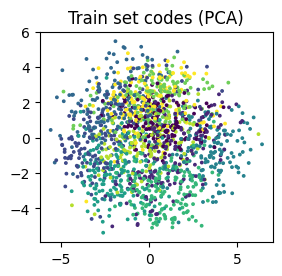

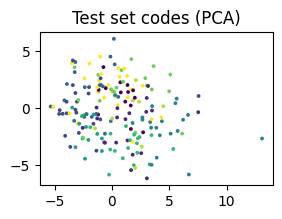

In [62]:
pca_model = PCA(n_components=2)

# plot pca of codes of images from train set
with torch.no_grad():
    Z_train = model(torch.from_numpy(X_train).float())[0]
    pca_model.fit(Z_train.detach().numpy())
    Z_train_pca = pca_model.transform(Z_train.detach().numpy())

fig, ax = plt.subplots(1, 1, figsize=(3,3))
ax.scatter(Z_train_pca[:, 0], Z_train_pca[:, 1], c=y_train, s=3)
ax.set_title("Train set codes (PCA)")
ax.set_aspect('equal')
plt.show()

# plot pca of codes of images from test set
with torch.no_grad():
    Z_test = model(torch.from_numpy(X_test).float())[0]
    Z_test_pca = pca_model.transform(Z_test.detach().numpy()) # do not fit new PCA but reuse from train set

fig, ax = plt.subplots(1, 1, figsize=(3,3))
ax.scatter(Z_test_pca[:, 0], Z_test_pca[:, 1], c=y_test, s=3)
ax.set_title("Test set codes (PCA)")
ax.set_aspect('equal')
plt.show()

<div style="color: green; font-weight:bold">
Ok. Plots not present in the correct solution.
</div>

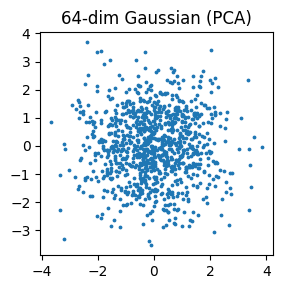

In [63]:
Z_random = torch.randn((1000, X_train.shape[1]))
Z_random_pca = PCA(n_components=2).fit_transform(Z_random.detach().numpy())

fig, ax = plt.subplots(1, 1, figsize=(3,3))
ax.scatter(Z_random_pca[:, 0], Z_random_pca[:, 1], s=3)
ax.set_title("64-dim Gaussian (PCA)")
ax.set_aspect('equal')
plt.show()

<div style="color: green; font-weight:bold">
Ok. Not present in the correct solution.
</div>

```
Codes are indeed standard normally distributed.
```

Now generate data with this model, with both the unimportant dimensions kept at zero (so
only the first k dimensions are sampled), and with the first k dimensions kept at some fixed
value and sampling the remaining 64 − k dimensions from the standad normal. The former
variant should work similar to the autoencoder from exercise 02, whereas the latter should
add diversity to the generated images, while keeping the general appearance fixed.

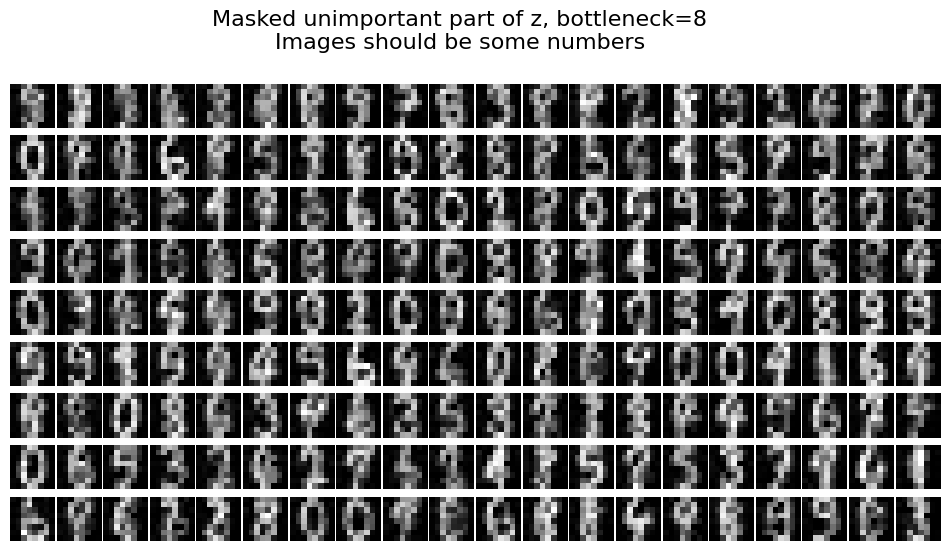

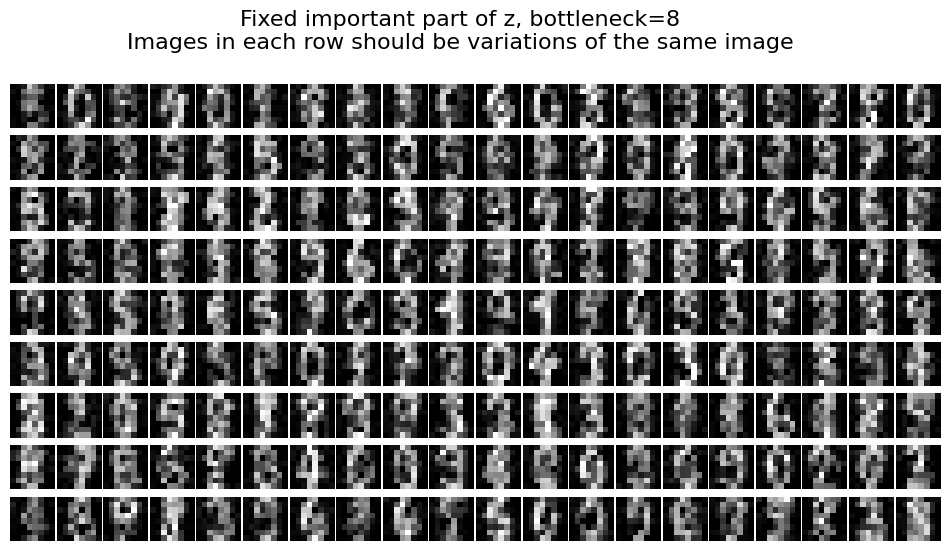

In [64]:
plot_model_details_bottleneck(model, X_train, bottleneck_size=8)

```
Comment: Here, we trained the model for 1000 epochs which took 13 minutes to obtain barely readable digits when unimportant part is also sampled.

However, at each row, digits are different which means that the unimportant part of the codes contain too much information as the images should change only slightly.
```

<div style="color: green; font-weight:bold">
Ok. Not present in the correct solution - they did not manage to obtain good results.
</div>

Experiment with this split method, where codes are categorized into "important" and "unimportant" and report your findings. Does the quality of the synthetic images improve, and do you observe the expected behavior of the two sampling schemes described above?

In [65]:
trained_model_and_results = {} # {bottleneck_size: (model, training_losses_df)}

<div style="color: green; font-weight:bold">
Ok.
</div>

In [66]:
BOTTLENECK = 8

model = RealNVP_1(64, 128, 4)
df = train_inn_bottleneck(model=model, X_train=X_train, X_test=X_test, 
               n_epochs=100, 
               batch_size=64,
               bottleneck_size=BOTTLENECK, 
               reconstruction_loss_weight=1,
               learning_rate=0.001)
trained_model_and_results[BOTTLENECK] = (model, df)

Epoch 0/100: train_loss=8346.3877, test_loss=8242.6680
	Train: nll_loss=4030.2358, reconstruction_loss=4316.1519
	Test: nll_loss=3981.3320, reconstruction_loss=4261.3354
Epoch 11/100: train_loss=453.0286, test_loss=497.2114
	Train: nll_loss=124.2843, reconstruction_loss=328.7443
	Test: nll_loss=125.0089, reconstruction_loss=372.2025
Epoch 22/100: train_loss=369.1934, test_loss=423.6378
	Train: nll_loss=107.7167, reconstruction_loss=261.4767
	Test: nll_loss=111.7406, reconstruction_loss=311.8972
Epoch 33/100: train_loss=299.2371, test_loss=383.2702
	Train: nll_loss=97.2563, reconstruction_loss=201.9808
	Test: nll_loss=102.6538, reconstruction_loss=280.6164
Epoch 44/100: train_loss=285.9995, test_loss=370.7202
	Train: nll_loss=92.6541, reconstruction_loss=193.3453
	Test: nll_loss=97.8216, reconstruction_loss=272.8985
Epoch 55/100: train_loss=259.1883, test_loss=364.2132
	Train: nll_loss=88.0695, reconstruction_loss=171.1188
	Test: nll_loss=95.5193, reconstruction_loss=268.6939
Epoch 66/1

<div style="color: green; font-weight:bold">
Ok.
</div>

In [68]:
BOTTLENECK = 4

model = RealNVP_1(64, 128, 4)
df = train_inn_bottleneck(model=model, X_train=X_train, X_test=X_test, 
               n_epochs=100, 
               batch_size=64,
               bottleneck_size=BOTTLENECK, 
               reconstruction_loss_weight=1,
               learning_rate=0.001)
trained_model_and_results[BOTTLENECK] = (model, df)

Epoch 0/100: train_loss=7291.3892, test_loss=7407.9062
	Train: nll_loss=3774.0872, reconstruction_loss=3517.3020
	Test: nll_loss=3856.8569, reconstruction_loss=3551.0496
Epoch 11/100: train_loss=688.1557, test_loss=727.3699
	Train: nll_loss=128.1124, reconstruction_loss=560.0432
	Test: nll_loss=128.5263, reconstruction_loss=598.8436
Epoch 22/100: train_loss=549.6133, test_loss=647.1281
	Train: nll_loss=112.0665, reconstruction_loss=437.5468
	Test: nll_loss=116.9304, reconstruction_loss=530.1977
Epoch 33/100: train_loss=499.7535, test_loss=577.2004
	Train: nll_loss=107.6790, reconstruction_loss=392.0745
	Test: nll_loss=110.9417, reconstruction_loss=466.2586
Epoch 44/100: train_loss=462.6442, test_loss=565.8112
	Train: nll_loss=101.8781, reconstruction_loss=360.7661
	Test: nll_loss=105.8129, reconstruction_loss=459.9983
Epoch 55/100: train_loss=442.1418, test_loss=547.7747
	Train: nll_loss=100.0648, reconstruction_loss=342.0770
	Test: nll_loss=104.1156, reconstruction_loss=443.6591
Epoch

<div style="color: green; font-weight:bold">
Ok.
</div>

In [70]:
BOTTLENECK = 2

model = RealNVP_1(64, 128, 4)
df = train_inn_bottleneck(model=model, X_train=X_train, X_test=X_test, 
               n_epochs=100, 
               batch_size=64,
               bottleneck_size=BOTTLENECK, 
               reconstruction_loss_weight=1,
               learning_rate=0.001)
trained_model_and_results[BOTTLENECK] = (model, df)

Epoch 0/100: train_loss=8364.9219, test_loss=8272.3350
	Train: nll_loss=4588.8813, reconstruction_loss=3776.0408
	Test: nll_loss=4497.8511, reconstruction_loss=3774.4836
Epoch 11/100: train_loss=958.2163, test_loss=1016.2428
	Train: nll_loss=130.4808, reconstruction_loss=827.7355
	Test: nll_loss=130.1268, reconstruction_loss=886.1160
Epoch 22/100: train_loss=886.8418, test_loss=965.0295
	Train: nll_loss=117.7119, reconstruction_loss=769.1299
	Test: nll_loss=119.7173, reconstruction_loss=845.3121
Epoch 33/100: train_loss=834.4369, test_loss=927.1970
	Train: nll_loss=108.5299, reconstruction_loss=725.9069
	Test: nll_loss=112.5885, reconstruction_loss=814.6085
Epoch 44/100: train_loss=795.7023, test_loss=881.3094
	Train: nll_loss=103.9501, reconstruction_loss=691.7521
	Test: nll_loss=107.4901, reconstruction_loss=773.8193
Epoch 55/100: train_loss=696.8083, test_loss=819.7403
	Train: nll_loss=98.8082, reconstruction_loss=598.0001
	Test: nll_loss=104.2272, reconstruction_loss=715.5131
Epoch

<div style="color: green; font-weight:bold">
Ok. Training 3 models could be in a single cell to make the notebook shorter.
</div>

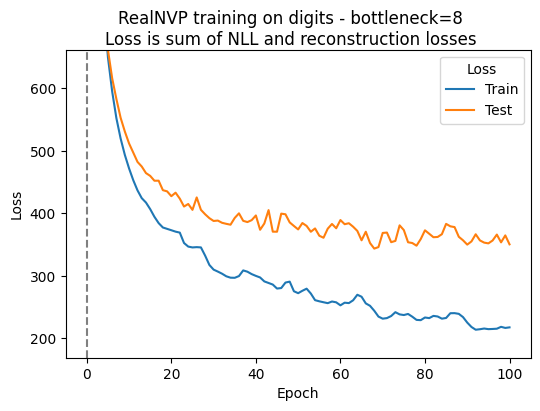

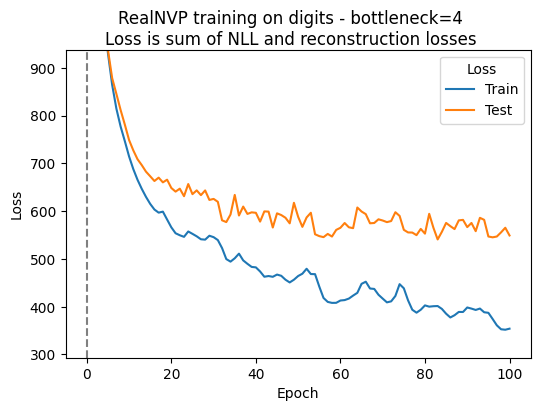

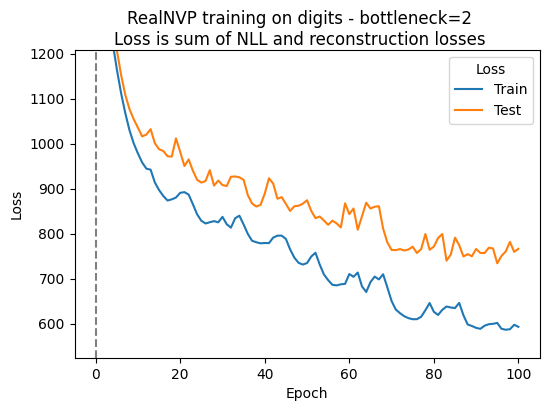

In [71]:
for bottleneck, (model, df) in trained_model_and_results.items():
    title=f"RealNVP training on digits - bottleneck={bottleneck}\nLoss is sum of NLL and reconstruction losses"
    plot_training_losses(df, title=title, starting_epoch=5)

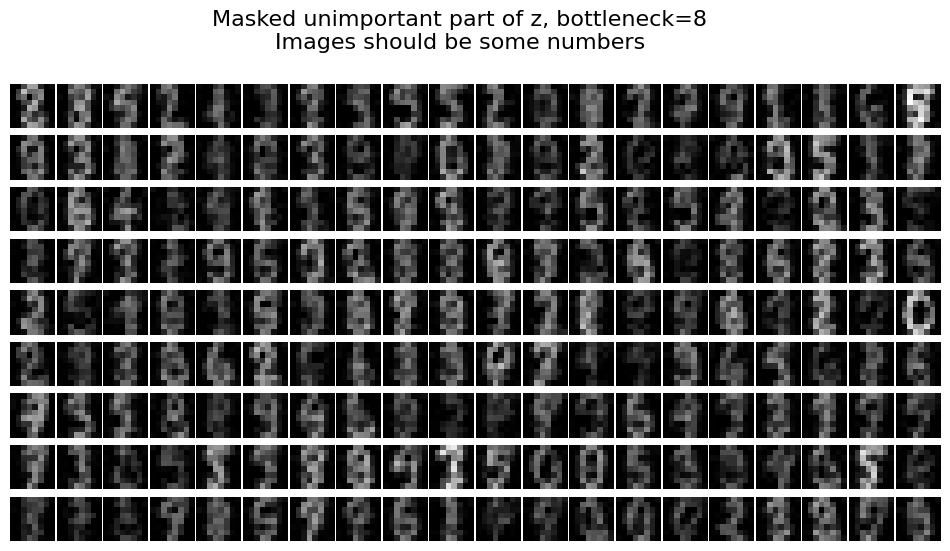

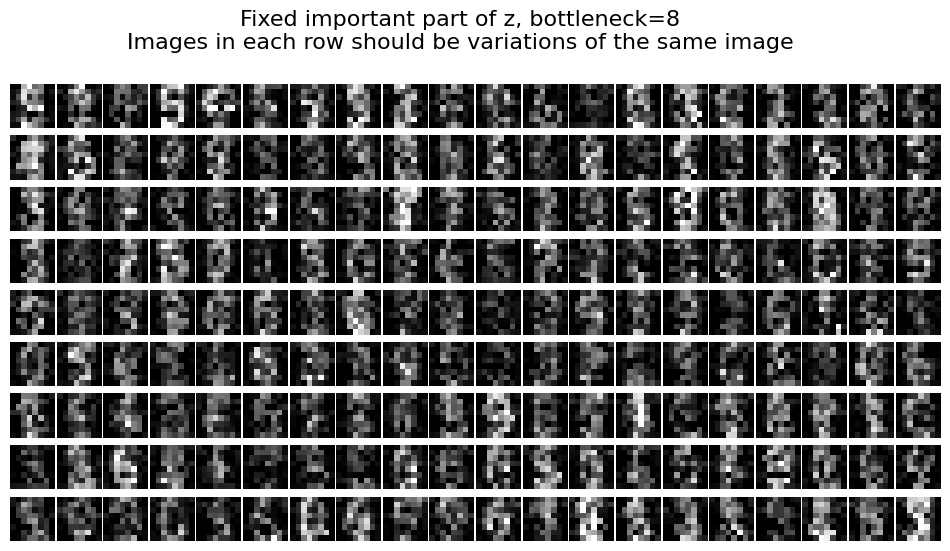

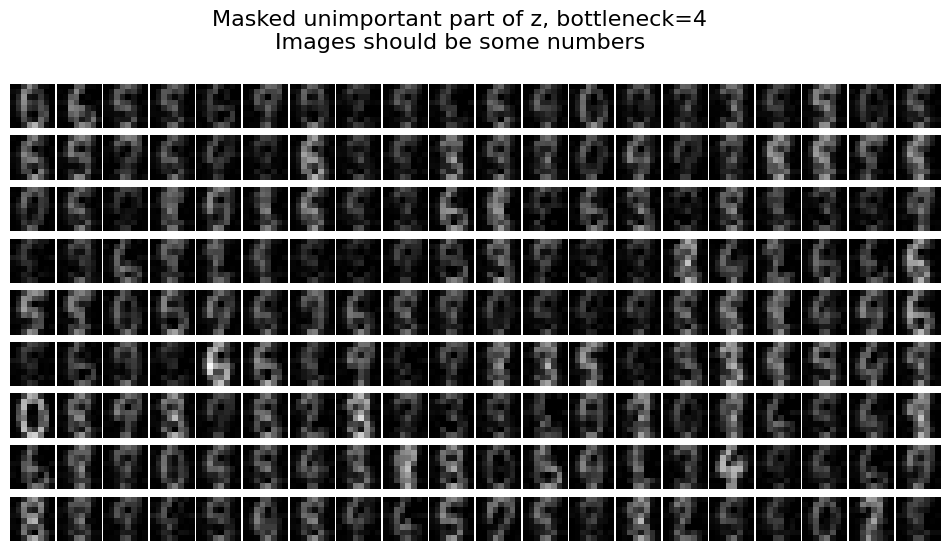

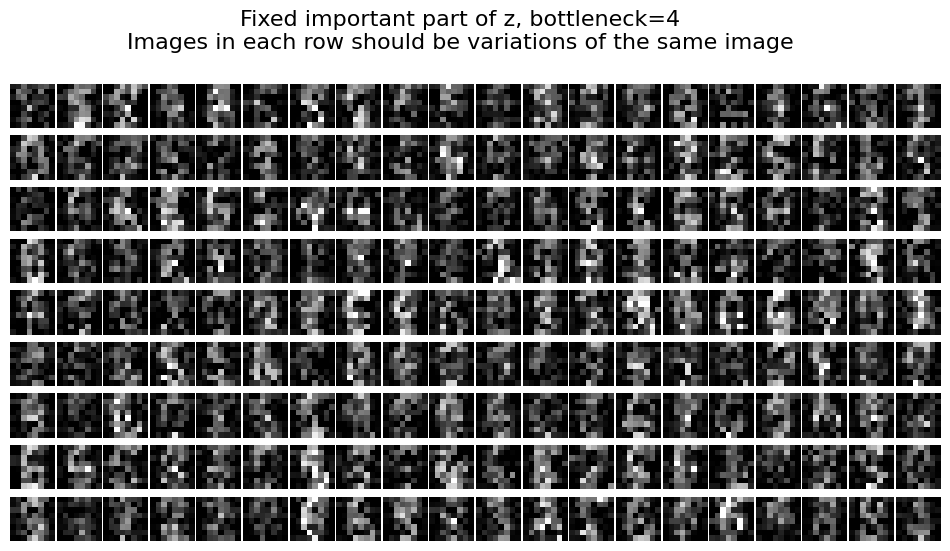

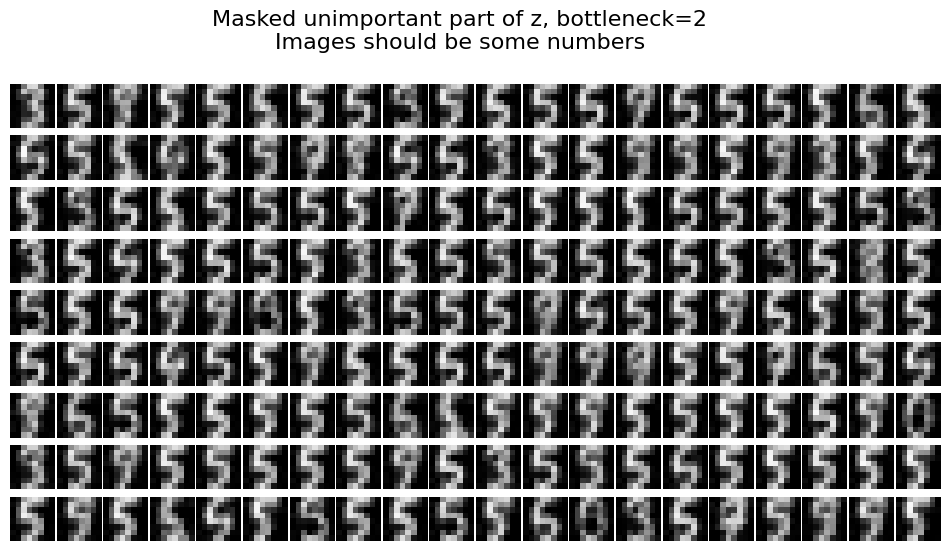

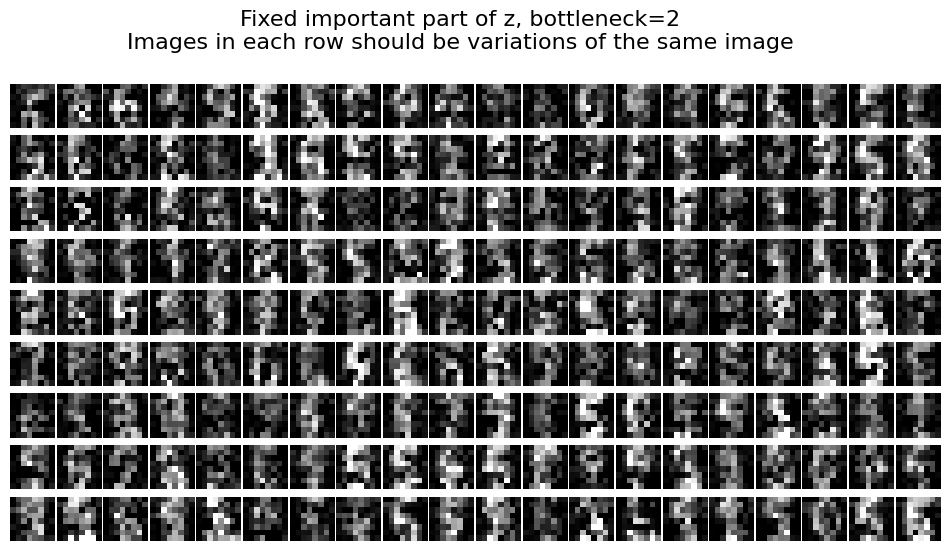

In [72]:
for bottleneck, (model, df) in trained_model_and_results.items():
    plot_model_details_bottleneck(model, X_train, bottleneck_size=bottleneck)

<div style="color: green; font-weight:bold">
Ok. Correct solution only included comparison of a single digit decoded after training on filtered dataset with only fives, and a single image decoded after training on the whole dataset. We show many more experiment results.
</div>

```
Comment:

Training curves show that the training could last longer to improve the loss. However, the overfitting is present for all bottlenecks.

Interestingly, model with bottleneck 2 can only sample some of the digits, model with bottleneck 4 has some more but unclear digits and model with bottleneck 8 can sample all digits although there are not that readable. 

Unfortunately, for each model, sampling the unimportant part makes the digits unreadable. One may argue that model with bottleneck 2 sometimes generates images that somewhat reseble digits.

Note: Here, training was performed for only 100 epochs due to time constraints to train models for 3 bottleneck sizes (earlier, a model with bottleneck 8 was trained for 1000 epochs and obtained better results).
```

<div style="color: green; font-weight:bold">
Ok. We obtained similar results as in the correct solution.
</div>

3. Another possibility is to use more training data. The listing below shows how you can import the MNIST digits dataset (which consists of 6000 training instances for each label) and downscale it to 8 × 8 on the fly. Evaluate your RealNVP on this dataset.

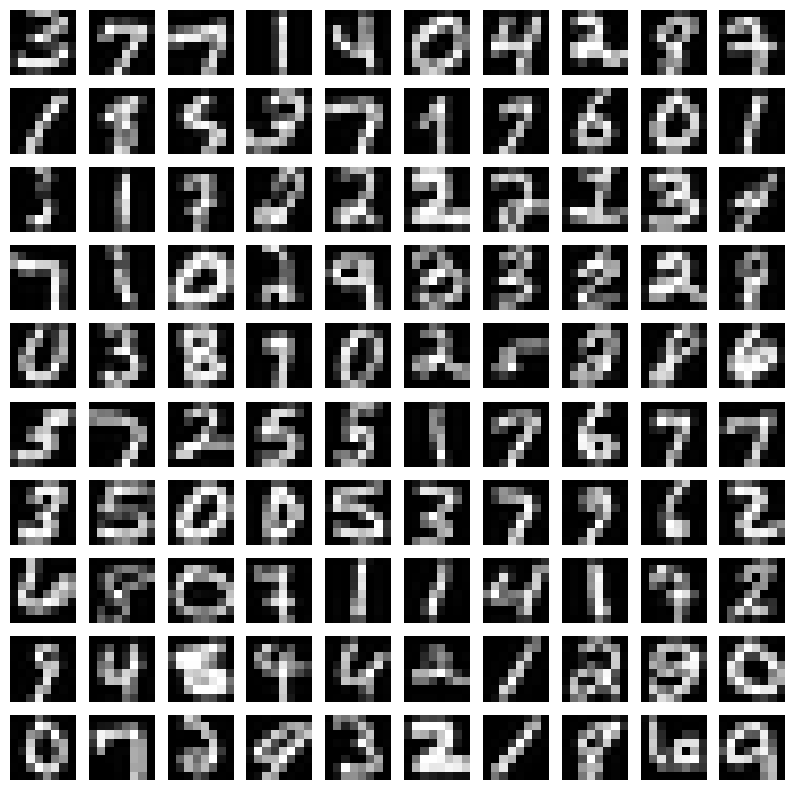

In [73]:
## Code provided in the task decription

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image, ImageFilter # install 'pillow ' to get PIL
import matplotlib.pyplot as plt

# define a functor to downsample images
class DownsampleTransform:
    def __init__ (self, target_shape, algorithm=Image.Resampling.LANCZOS):
        self.width, self.height = target_shape
        self.algorithm = algorithm

    def __call__ (self, img):
        img = img.resize((self.width+2, self.height+2), self.algorithm)
        img = img.crop((1, 1, self.width+1, self.height+1))
        return img

# concatenate a few transforms
transform = transforms.Compose([
    DownsampleTransform(target_shape=(8, 8)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
    ])

# download MNIST
mnist_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

# create a DataLoader that serves minibatches of size 100
data_loader = DataLoader(mnist_dataset, batch_size=100, shuffle=True)

# visualize the first batch of downsampled MNIST images
def show_first_batch(data_loader):
    for batch in data_loader:
        x, y = batch
        fig = plt.figure(figsize=(10, 10))
        for i, img in enumerate(x):
            ax = fig.add_subplot(10, 10, i+1)
            ax.imshow(img.reshape(8, 8), cmap='gray')
            ax.axis('off')
        break

show_first_batch(data_loader)

<div style="color: green; font-weight:bold">
Ok, Not present in the correct solution, copied from task description
</div>

In [74]:
# turn data from dataloader into numpy -> earlier training code will work without modifications
data_loader = DataLoader(mnist_dataset, batch_size=len(mnist_dataset), shuffle=True)
X, y = next(iter(data_loader))
X = X.detach().numpy().reshape(len(mnist_dataset), -1) * 16 # rescale to 0-16 range to be the same as in other tasks
y = y.detach().numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((54000, 64), (54000,), (6000, 64), (6000,))

<div style="color: green; font-weight:bold">
Ok, Not present in the correct solution.
</div>

Epoch 0/3: train_loss=7748.5015, test_loss=7683.5225
Epoch 1/3: train_loss=86.7349, test_loss=51.3153
Epoch 2/3: train_loss=44.5128, test_loss=38.5918
Epoch 3/3: train_loss=34.8403, test_loss=31.1751


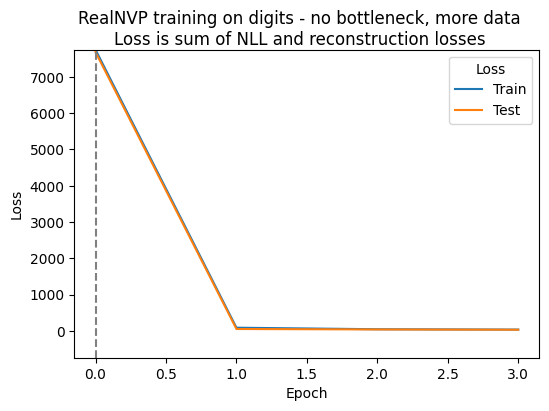

In [75]:
model = RealNVP_1(64, 128, 8)
df = train_inn(model=model, X_train=X_train, X_test=X_test, 
               n_epochs=3, 
               batch_size=64,
               learning_rate=0.001)

title=f"RealNVP training on digits - no bottleneck, more data\nLoss is sum of NLL and reconstruction losses"
plot_training_losses(df, title=title, starting_epoch=0)

<div style="color: green; font-weight:bold">
Not present in the correct solution. We could remove data point from the 0-th epoch (before training) to make the plot readable.
</div>

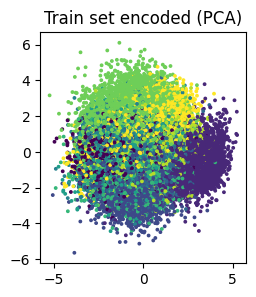

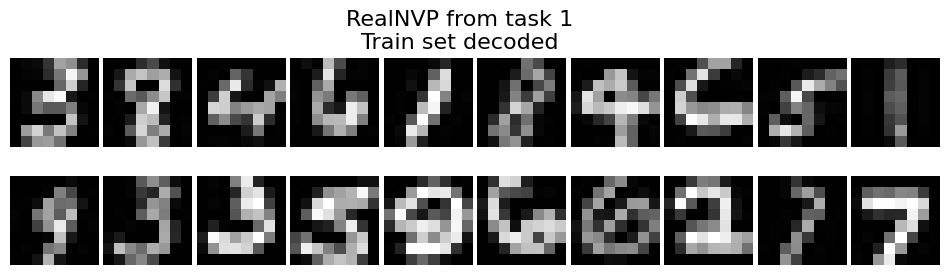

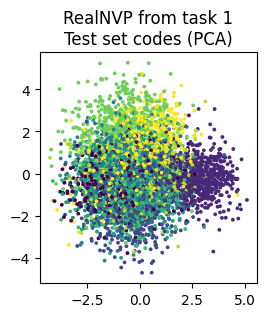

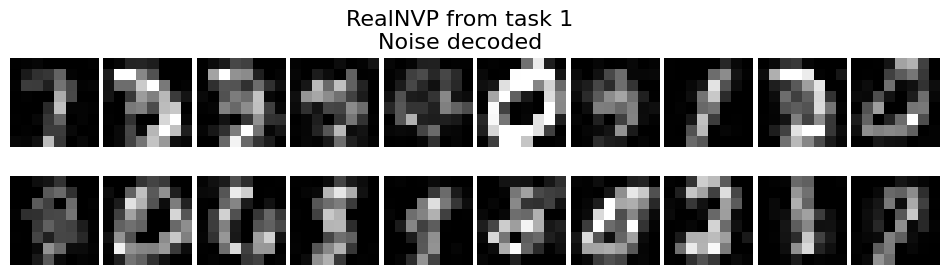

In [76]:
plot_model_details_pca(model, X_train, y_train, X_test, y_test, title="RealNVP from task 1")

<div style="color: green; font-weight:bold">
Ok, Not present in the correct solution.
</div>

```
Comment:

Training on more data for the same number of epochs and of the same models architecture did not improve the results. Probably a longer training would show the differences and improvements.

Note: Previously, model was trained on 1617 images for 100 epochs with batch size 64. To get the same length of training on 56000 images, we now trained for 100 / (54000/1617) = 3 epochs with the same batch size. 
```

## 4 Higher-dimensional data with a conditional INN
Repeat task 3 with a conditional RealNVP using the digit labels as a condition. Generate data with your model for predefined labels. Do the synthetic digits look like examples for the desired digit label?


<div style="color: green; font-weight:bold">
Different interpretation of the task:

- the correct solution repeated task 3 by training a conditional RealNVP on the small digits dataset, which is repeating subtask 3.1 where a simple RealNVP from task 1 was evaluated.
- we interpreted this task as repeating subtask 3.2 where a RealNVP with bottleneck was used. This is why we trained a conditional RealNVP with different bottlenecks. 

Other than that, our solutions are comparable.
</div>

In [ ]:
# training function conditional (task 2) with added artificial bottleneck

def custom_negative_log_likelihood_loss(model_outputs, log_det_jacobian_sum):
    return torch.mean(torch.sum(0.5 * torch.pow(model_outputs, 2), dim=1) - log_det_jacobian_sum)

def custom_reconstruction_loss(model_outputs, original_data):
    return torch.mean(torch.sum(torch.pow(model_outputs - original_data, 2), dim=1))

def train_inn_conditional_bottleneck(model, X_train, X_test, y_train, y_test, n_epochs, batch_size, learning_rate=0.001, size_of_the_training_set=-1, 
                          nnl_loss_func=custom_negative_log_likelihood_loss, 
                          reconstruction_loss_func=custom_reconstruction_loss, bottleneck_size=8, # Added - bottleneck and reconstruction loss
                          reconstruction_loss_weight=1.0): # Added - weight of reconstruction loss - not used anywhere but thought it might help in training
    """
    Args:
        model (nn.Module): a RealNVP model which returns z and log_det_jacobian_sum
        X_train (np.ndarray): the training data
        X_test (np.ndarray): the test data
        y_train (np.ndarray): the training data conditions
        y_test (np.ndarray): the test data conditions
        n_epochs (int): the number of training epochs
        batch_size (int): the batch size
        learning_rate (float): the learning rate
        size_of_the_training_set (int): subset of the training set to use (default: -1, i.e. use the whole training set)
        nnl_loss (function): the negative log likelihood loss function to use (default: custom_negative_log_likelihood_loss)
    # Added - bottleneck and reconstruction loss
        reconstruction_loss (function): the reconstruction loss function to use (default: custom_reconstruction_loss)
        bottleneck_size (int): the size of the bottleneck (default: 2)
        reconstruction_loss_weight (float): the weight of the reconstruction loss (default: 1.0)
    """
    
    # Added - function to compute (weighted) sum of nll and reconstruction loss that adds bottleneck
    def compute_loss_with_bottleneck_conditional(model, X, y_onehotencoded_conditions, 
                                     nnl_loss_func=nnl_loss_func,
                                     reconstruction_loss_func=reconstruction_loss_func,
                                     bottleneck_size=bottleneck_size,
                                     reconstruction_loss_weight=reconstruction_loss_weight):
        z, log_det_jacobian_sum = model(X, y_onehotencoded_conditions)
        nll_loss = nnl_loss_func(z, log_det_jacobian_sum)
        ## Added part - mask bottlenecked part of z, reconstruct, get reconstruction loss and add to nll loss
        z_bottlenecked = torch.zeros_like(z)
        z_bottlenecked[:, :bottleneck_size] = z[:, :bottleneck_size]
        x_reconstructed = model.decoder(z_bottlenecked, y_onehotencoded_conditions)
        reconstruction_loss = reconstruction_loss_func(x_reconstructed, X)
        loss = nll_loss + reconstruction_loss * reconstruction_loss_weight
        return loss, (nll_loss, reconstruction_loss)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    test_losses = []

    X_train = X_train[:size_of_the_training_set]
    y_train = y_train[:size_of_the_training_set]
    
    data_train = torch.from_numpy(X_train).float()
    y_train = torch.from_numpy(y_train).float()
    y_onehotencoded_conditions_train = torch.eye(model.condition_size)[y_train.long()].float()
    data_test = torch.from_numpy(X_test).float()
    y_test = torch.from_numpy(y_test).float()
    y_onehotencoded_conditions_test = torch.eye(model.condition_size)[y_test.long()].float() 

    # loss before training
    with torch.no_grad():
        loss, (nll_loss_train, reconstruction_loss_train) = compute_loss_with_bottleneck_conditional(model, data_train, y_onehotencoded_conditions_train)
        train_losses.append(loss.item())
        loss, (nll_loss_test, reconstruction_loss_test) = compute_loss_with_bottleneck_conditional(model, data_test, y_onehotencoded_conditions_test)
        test_losses.append(loss.item())
    print(f"Epoch 0/{n_epochs}: train_loss={train_losses[-1]:.4f}, test_loss={test_losses[-1]:.4f}")
    print(f"\tTrain: nll_loss={nll_loss_train:.4f}, reconstruction_loss={reconstruction_loss_train:.4f}")
    print(f"\tTest: nll_loss={nll_loss_test:.4f}, reconstruction_loss={reconstruction_loss_test:.4f}")

    # training
    for epoch in range(n_epochs):
        train_loss = 0
        train_nll_loss, train_reconstruction_loss = 0, 0
        test_loss = 0
        test_nll_loss, test_reconstruction_loss = 0, 0
        for i in range(0, len(X_train), batch_size):
            data = data_train[i:i+batch_size]
            y_data = y_onehotencoded_conditions_train[i:i+batch_size] 
            optimizer.zero_grad()
            loss, (nll_loss, reconstruction_loss) = compute_loss_with_bottleneck_conditional(model, data, y_data)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * len(data)
            train_nll_loss += nll_loss.item() * len(data)
            train_reconstruction_loss += reconstruction_loss.item() * len(data)
        train_loss /= len(X_train)
        train_losses.append(train_loss)
        train_nll_loss /= len(X_train)
        train_reconstruction_loss /= len(X_train)

        with torch.no_grad():
            for i in range(0, len(X_test), batch_size):
                data = data_test[i:i+batch_size]
                y_data = y_onehotencoded_conditions_test[i:i+batch_size] 
                loss, (nll_loss, reconstruction_loss) = compute_loss_with_bottleneck_conditional(model, data, y_data)
                test_loss += loss.item() * len(data)
                test_nll_loss += nll_loss.item() * len(data)
                test_reconstruction_loss += reconstruction_loss.item() * len(data)
            test_loss /= len(X_test)
            test_losses.append(test_loss)
            test_nll_loss /= len(X_test)
            test_reconstruction_loss /= len(X_test)
            
        if (epoch+1) % (n_epochs//10+1) == 0 or epoch == n_epochs-1:
            print(f"Epoch {epoch+1}/{n_epochs}: train_loss={train_loss:.4f}, test_loss={test_loss:.4f}")
            print(f"\tTrain: nll_loss={train_nll_loss:.4f}, reconstruction_loss={train_reconstruction_loss:.4f}")
            print(f"\tTest: nll_loss={test_nll_loss:.4f}, reconstruction_loss={test_reconstruction_loss:.4f}")
    df = pd.DataFrame({'train': train_losses, 'test': test_losses, 'epoch': list(range(n_epochs+1))})
    return df

<div style="color: green; font-weight:bold">
Ok, correct solution has a more concise code Again, they load the dataset at every epoch which is strange and inefficient.

As stated at the beginning of task 4, we train a conditional RealNVP with bottleneck whereas the correct solution interpreted this task as using a conditional RealNVP without bottleneck.
</div>

In [ ]:
def plot_model_details_bottleneck_conditional(model, data_shape, bottleneck_size):
    num_of_classes = model.condition_size
    y = np.arange(num_of_classes).repeat(1000)
    np.random.shuffle(y)
    y_onehotencoded_conditions = torch.eye(num_of_classes)[torch.from_numpy(y).long()].float() # Added - one-hot encode y
    with torch.no_grad():
        Z_random_masked_unimportant = torch.zeros((1000, data_shape))
        Z_random_masked_unimportant[:, :bottleneck_size] =  torch.randn((1000, bottleneck_size))
        X_masked_unimportant = model.decoder(Z_random_masked_unimportant, y_onehotencoded_conditions[:1000]).detach().numpy()

    # plot rows of digits with masked unimportant 
    fig, axs = plt.subplots(num_of_classes, 20, figsize=(12, 1+5*(num_of_classes/10)))
    fig.suptitle(f"Masked unimportant part of z, bottleneck={bottleneck_size}\nImages should be some numbers\nEach row was conditioned with same class y", y=1, fontsize=16)
    fig.subplots_adjust(hspace=0.05, wspace=0.05)

    X_masked_unimportant[X_masked_unimportant < 0] = 0
    X_masked_unimportant[X_masked_unimportant > 16] = 16
    for row_id, ax_row in enumerate(axs):
        X_class_row_id = X_masked_unimportant[y[:1000] == row_id]
        for i, axi in enumerate(ax_row):
            im = axi.imshow(X_class_row_id[i].reshape(8, 8), cmap="gray")
            im.set_clim(0, 16)
            axi.axis("off")
            if i == 0:
                axi.text(-12, 5, f"y={row_id}", fontsize=16)

    plt.show()

    # plot rows of digits with fixed important
    fig, axs = plt.subplots(num_of_classes, 20, figsize=(12, 1+5*(num_of_classes/10)))
    fig.suptitle(f"Fixed important part of z and randomized rest, bottleneck={bottleneck_size}\nImages in each row should be variations of the same image\nEach row was conditioned with same class y", y=1, fontsize=16)
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for row_id, ax_row in enumerate(axs):
        with torch.no_grad():
            y_onehotencoded_row_id_repeated = torch.eye(num_of_classes)[row_id].repeat(100, 1)
            Z_random_fixed_important = torch.randn((100, data_shape))
            fixed_part = torch.randn((100, bottleneck_size))
            Z_random_fixed_important[:, :bottleneck_size] = fixed_part
            X_fixed_important = model.decoder(Z_random_fixed_important, y_onehotencoded_row_id_repeated).detach().numpy()

        X_fixed_important[X_fixed_important < 0] = 0
        X_fixed_important[X_fixed_important > 16] = 16
        for i, axi in enumerate(ax_row):
            im = axi.imshow(X_fixed_important[i].reshape(8, 8), cmap="gray")
            im.set_clim(0, 16)
            axi.axis("off")
            if i == 0:
                axi.text(-12, 5, f"y={row_id}", fontsize=16)
    plt.show()

<div style="color: green; font-weight:bold">
Ok.
</div>

In [ ]:
trained_model_and_results = {} # {bottleneck_size: (model, training_losses_df)}

<div style="color: green; font-weight:bold">
Ok.
</div>

In [ ]:
BOTTLENECK = 2

model = RealNVP_2(input_size=64, hidden_size=128, blocks=4, condition_size=10)
df = train_inn_conditional_bottleneck(model=model, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test,
               n_epochs=100, 
               batch_size=64,
               bottleneck_size=BOTTLENECK,
               reconstruction_loss_weight=1,
               learning_rate=0.001)
trained_model_and_results[BOTTLENECK] = (model, df)

Epoch 0/100: train_loss=7699.9155, test_loss=7821.9355
	Train: nll_loss=3986.5911, reconstruction_loss=3713.3245
	Test: nll_loss=4054.5117, reconstruction_loss=3767.4241
Epoch 11/100: train_loss=675.2323, test_loss=714.3896
	Train: nll_loss=115.9558, reconstruction_loss=559.2765
	Test: nll_loss=117.5412, reconstruction_loss=596.8484
Epoch 22/100: train_loss=569.4613, test_loss=634.2570
	Train: nll_loss=98.7850, reconstruction_loss=470.6763
	Test: nll_loss=104.6842, reconstruction_loss=529.5728
Epoch 33/100: train_loss=522.5713, test_loss=610.6050
	Train: nll_loss=90.7323, reconstruction_loss=431.8390
	Test: nll_loss=99.6243, reconstruction_loss=510.9808
Epoch 44/100: train_loss=485.0403, test_loss=579.4806
	Train: nll_loss=85.7619, reconstruction_loss=399.2784
	Test: nll_loss=96.5949, reconstruction_loss=482.8857
Epoch 55/100: train_loss=468.0321, test_loss=607.6969
	Train: nll_loss=82.4326, reconstruction_loss=385.5996
	Test: nll_loss=96.1722, reconstruction_loss=511.5247
Epoch 66/100

<div style="color: green; font-weight:bold">
Ok.
</div>

In [ ]:
BOTTLENECK = 4

model = RealNVP_2(input_size=64, hidden_size=128, blocks=4, condition_size=10)
df = train_inn_conditional_bottleneck(model=model, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test,
               n_epochs=100, 
               batch_size=64,
               bottleneck_size=BOTTLENECK,
               reconstruction_loss_weight=1,
               learning_rate=0.001)
trained_model_and_results[BOTTLENECK] = (model, df)

Epoch 0/100: train_loss=6618.0156, test_loss=6682.2847
	Train: nll_loss=2732.5525, reconstruction_loss=3885.4634
	Test: nll_loss=2760.2502, reconstruction_loss=3922.0344
Epoch 11/100: train_loss=586.3420, test_loss=638.9027
	Train: nll_loss=120.0788, reconstruction_loss=466.2631
	Test: nll_loss=121.3561, reconstruction_loss=517.5465
Epoch 22/100: train_loss=450.7616, test_loss=531.0582
	Train: nll_loss=102.3343, reconstruction_loss=348.4274
	Test: nll_loss=105.4163, reconstruction_loss=425.6419
Epoch 33/100: train_loss=409.8211, test_loss=517.9702
	Train: nll_loss=94.6100, reconstruction_loss=315.2111
	Test: nll_loss=99.4180, reconstruction_loss=418.5522
Epoch 44/100: train_loss=370.2377, test_loss=493.1154
	Train: nll_loss=88.9399, reconstruction_loss=281.2978
	Test: nll_loss=95.9873, reconstruction_loss=397.1281
Epoch 55/100: train_loss=355.8330, test_loss=464.4004
	Train: nll_loss=84.3813, reconstruction_loss=271.4517
	Test: nll_loss=93.3178, reconstruction_loss=371.0826
Epoch 66/10

<div style="color: green; font-weight:bold">
Ok.
</div>

In [ ]:
BOTTLENECK = 8

model = RealNVP_2(input_size=64, hidden_size=128, blocks=4, condition_size=10)
df = train_inn_conditional_bottleneck(model=model, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test,
               n_epochs=100, 
               batch_size=64,
               bottleneck_size=BOTTLENECK,
               reconstruction_loss_weight=1,
               learning_rate=0.001)
trained_model_and_results[BOTTLENECK] = (model, df)
# 64, 128, 4; 1000, 64, 8, 1 -> 1min10s, train nll 67, reconstruction 123

Epoch 0/100: train_loss=7080.7212, test_loss=7076.1279
	Train: nll_loss=3575.2302, reconstruction_loss=3505.4910
	Test: nll_loss=3559.5525, reconstruction_loss=3516.5757
Epoch 11/100: train_loss=427.1782, test_loss=490.8812
	Train: nll_loss=117.3213, reconstruction_loss=309.8569
	Test: nll_loss=120.8161, reconstruction_loss=370.0651
Epoch 22/100: train_loss=326.5895, test_loss=402.8396
	Train: nll_loss=98.8390, reconstruction_loss=227.7505
	Test: nll_loss=103.8476, reconstruction_loss=298.9920
Epoch 33/100: train_loss=283.4669, test_loss=370.4730
	Train: nll_loss=89.0524, reconstruction_loss=194.4144
	Test: nll_loss=95.6533, reconstruction_loss=274.8196
Epoch 44/100: train_loss=277.4891, test_loss=368.9593
	Train: nll_loss=84.5719, reconstruction_loss=192.9173
	Test: nll_loss=93.9351, reconstruction_loss=275.0243
Epoch 55/100: train_loss=231.9818, test_loss=353.3708
	Train: nll_loss=77.7939, reconstruction_loss=154.1879
	Test: nll_loss=90.0818, reconstruction_loss=263.2890
Epoch 66/100

<div style="color: green; font-weight:bold">
Ok, could be more concise.
</div>

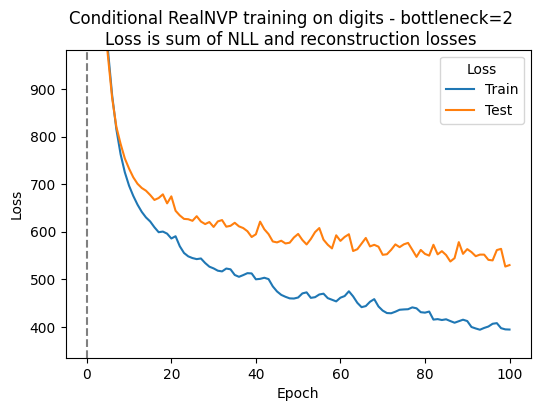

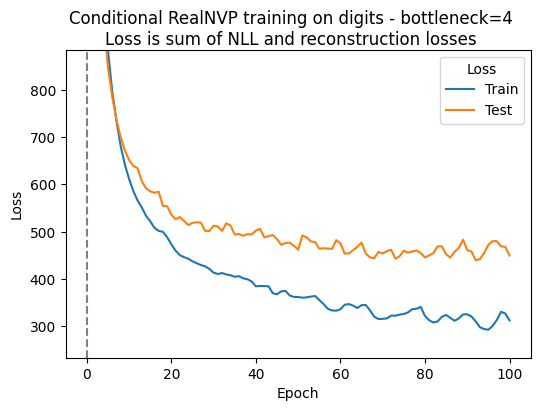

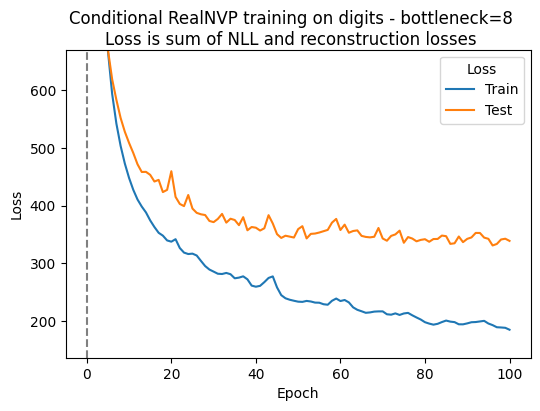

In [ ]:
for bottleneck, (model, df) in trained_model_and_results.items():
    title=f"Conditional RealNVP training on digits - bottleneck={bottleneck}\nLoss is sum of NLL and reconstruction losses"
    plot_training_losses(df, title=title, starting_epoch=5)

<div style="color: green; font-weight:bold">
Ok. Plot not present in the correct solution.
</div>

```
Comment:

Training could benefit from more epochs, and slightly lower learning rate or bigger batch size (training loss fluctuates a bit).

Overfitting - test loss stopped decreasing quite early, interesting.
```

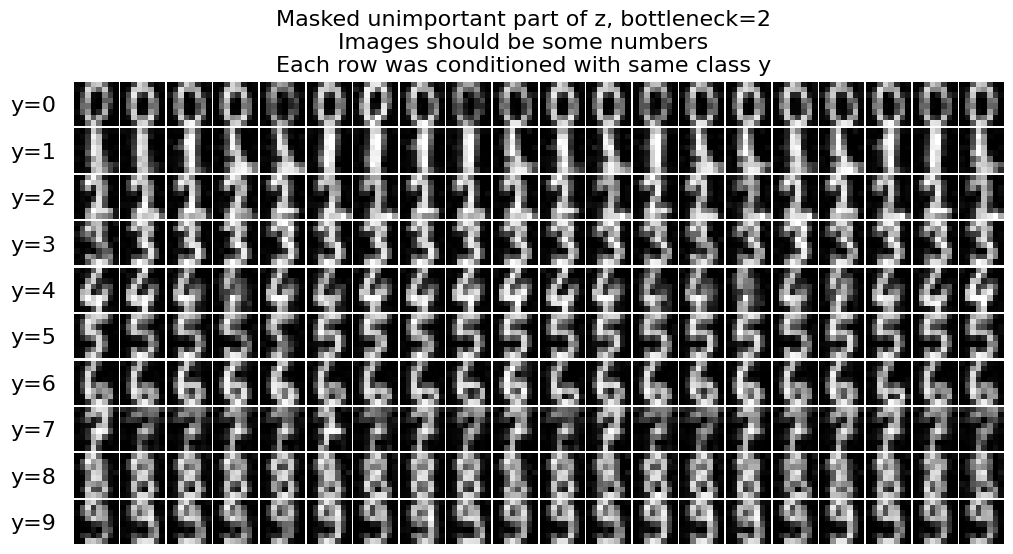

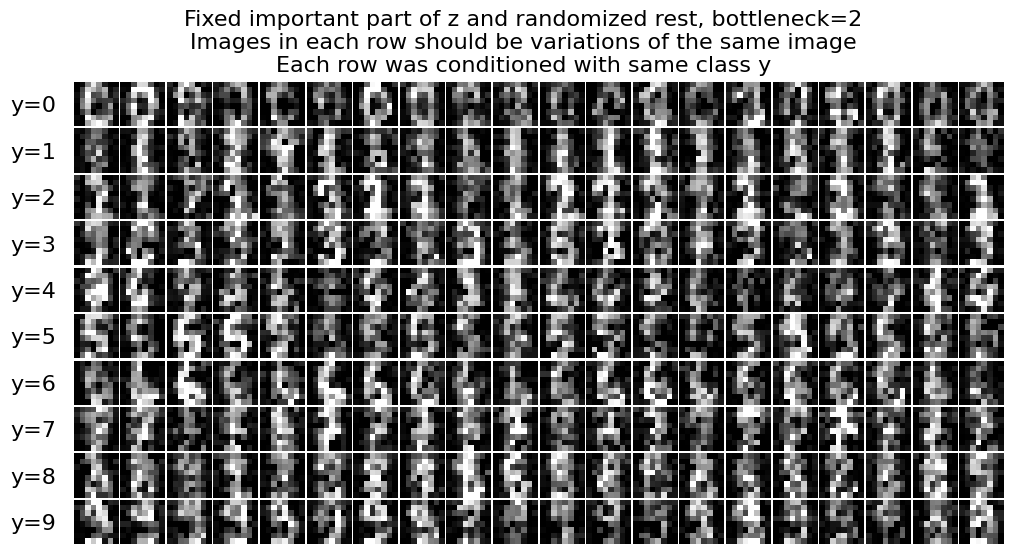

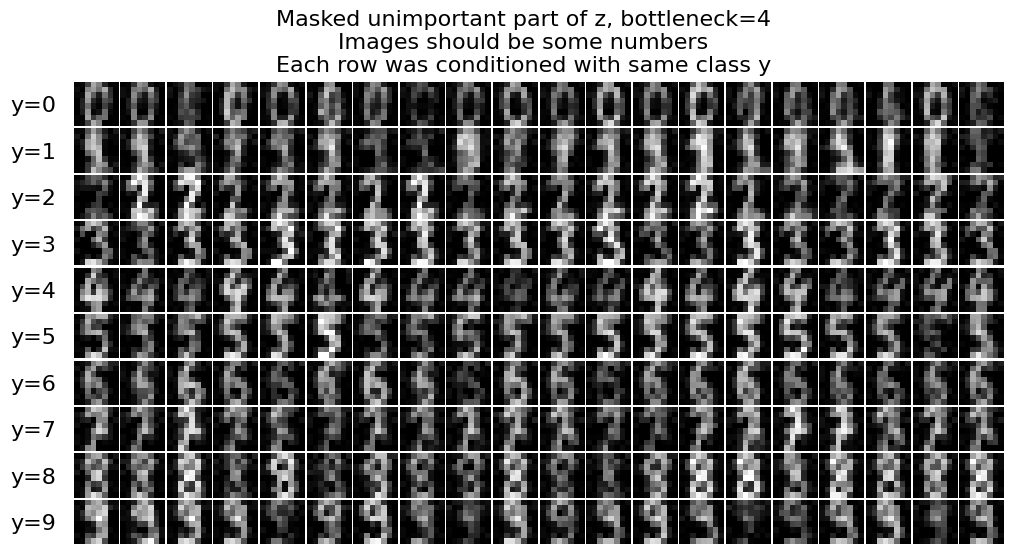

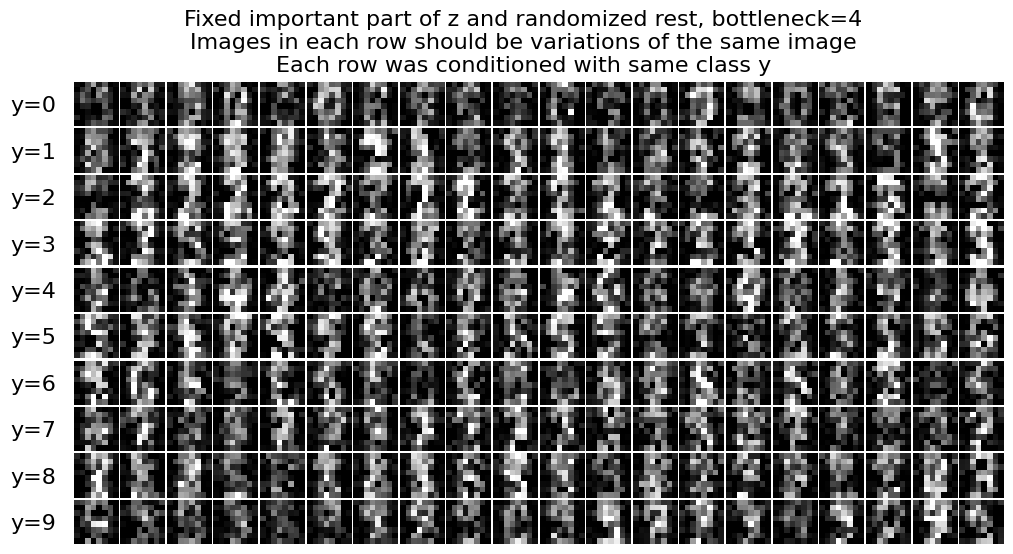

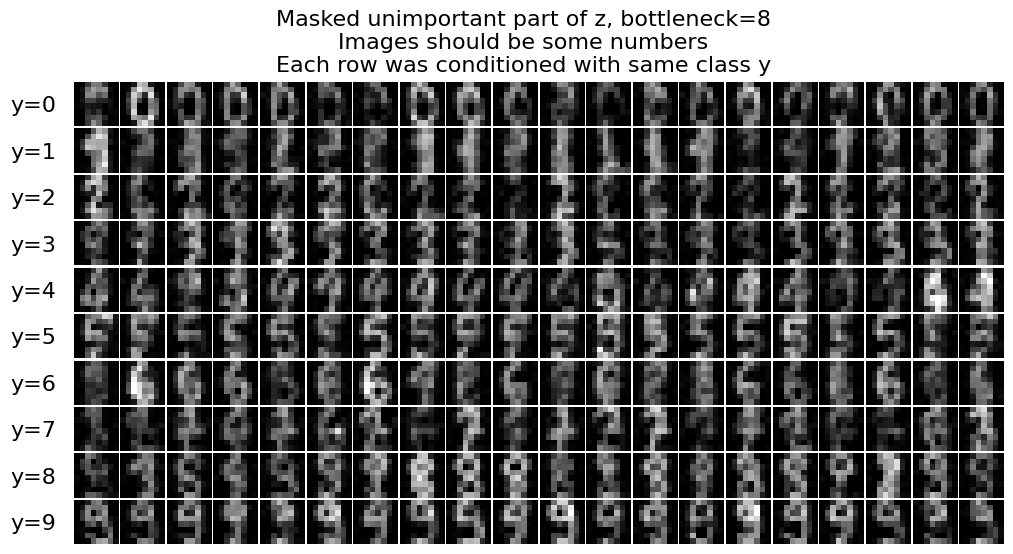

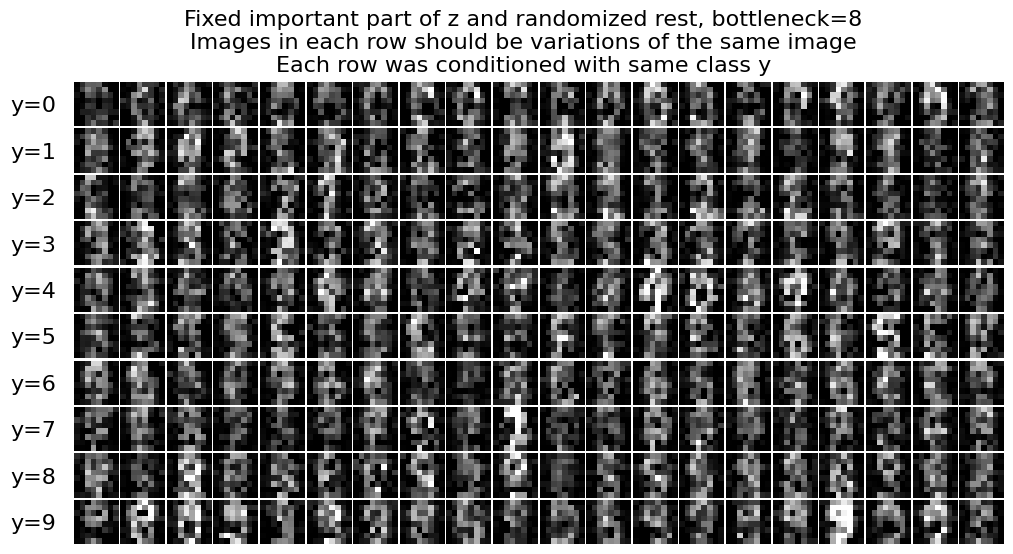

In [ ]:
for bottleneck, (model, df) in trained_model_and_results.items():
    plot_model_details_bottleneck_conditional(model, data_shape=X_train.shape[1], bottleneck_size=bottleneck)

<div style="color: green; font-weight:bold">
Ok. The correct solution would benefit from showing more of the generated digits for each class label (they show only one).

Our results are similar to those obtained in the correct solution but are more extensive. In our experiments we used a conditional RealNVP with bottleneck which allowed for many more ways to compare the results.
</div> 

```
Comment: 

Bottleneck 2:
- sampled only important part - good results
- fixed important, sampled unimportant - does add diversity and the general appearance is somewhat fixed. Not too readable though.

Bottleneck 4:
- sampled only important part - a bit worse results, but still readable
- fixed important, sampled unimportant - much worse, not readable

Bottleneck 8:
- sampled only important part - even worse, mostly readable but sometimes generated digit from another class then condition.
- fixed important, sampled unimportant - similar to bottleneck 4, not readable
```

If yes, you should again check the accuracy and confidence with a random forest classiffier as in exercise 02.

In [ ]:
clf = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=0)
clf.fit(X_train, y_train)
print(f'Random forest accuracy - train: {clf.score(X_train, y_train):.4f}, test: {clf.score(X_test, y_test):.4f}')

Random forest accuracy train: 0.9975, test: 0.9778


<div style="color: green; font-weight:bold">
Equivalent to the correct solution. They should also print the accuracy to allow for better comparison between ours and theirs solution results.
</div>

-------------- Below - sample from bottleneck important part only --------------


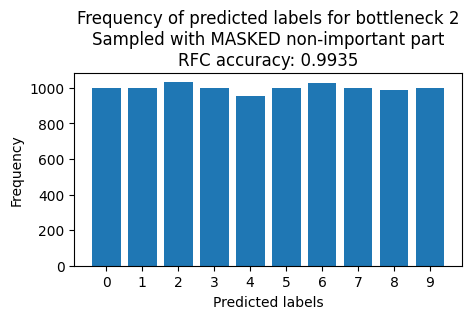

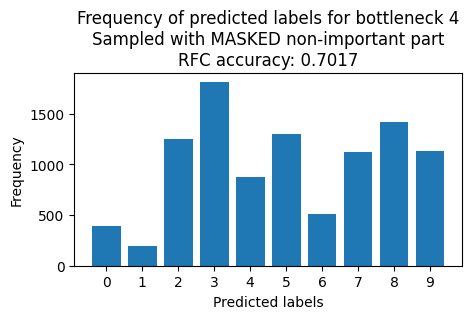

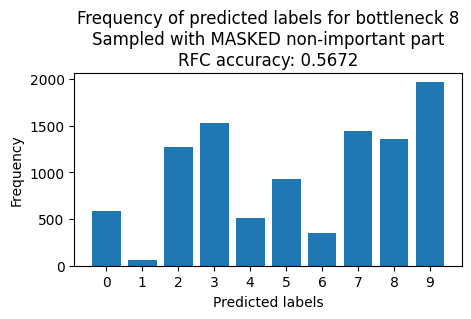

-------------- Below - sample from whole z --------------


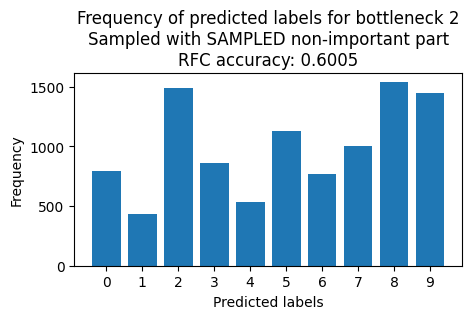

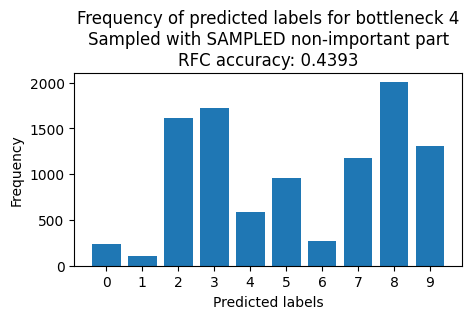

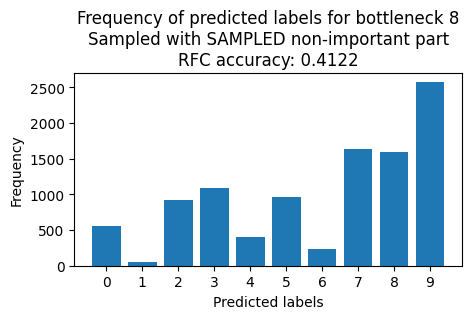

In [ ]:
def plot_frequency_predicted_labels(y_pred, title):
    unique, counts = np.unique(y_pred, return_counts=True)
    counts_dict = dict(zip(unique, counts))
    for i in range(10):
        if i not in counts_dict.keys():
            counts_dict[i] = 0
    counts = list(counts_dict.values())
    unique = list(counts_dict.keys())
    
    plt.rcParams["figure.figsize"] = (5,2.5)
    plt.bar(unique, counts)
    plt.xticks(np.arange(10))
    plt.title(title)
    plt.xlabel('Predicted labels')
    plt.ylabel('Frequency')
    plt.show()

conditions = np.arange(10)
y_onehotencoded_conditions = np.eye(10)[conditions]
conditions_repeated = np.repeat(conditions, 1000)
y_onehotencoded_conditions_repeated = np.repeat(y_onehotencoded_conditions, 1000, axis=0)


print("-------------- Below - sample from bottleneck important part only --------------")
# sample from important part only 
for bottleneck, (model, df) in trained_model_and_results.items():
    with torch.no_grad():
        Z_random_masked_unimportant = torch.zeros((10000, 64))
        Z_random_masked_unimportant[:, :bottleneck] =  torch.randn((10000, bottleneck))
        X_masked_unimportant = model.decoder(Z_random_masked_unimportant, torch.from_numpy(y_onehotencoded_conditions_repeated).float()).detach().numpy()
    y_pred = clf.predict(X_masked_unimportant)
    accuracy = np.mean(y_pred == conditions_repeated)
    title = f"Frequency of predicted labels for bottleneck {bottleneck}\nSampled with MASKED non-important part\nRFC accuracy: {accuracy:.4f}"
    plot_frequency_predicted_labels(y_pred, title)

print("-------------- Below - sample from whole z --------------")
# sample from whole z
for bottleneck, (model, df) in trained_model_and_results.items():
    X_sampled = model.sample(num_samples=1000, conditions=y_onehotencoded_conditions).detach().numpy()
    y_pred = clf.predict(X_sampled)
    accuracy = np.mean(y_pred == conditions_repeated)
    title = f"Frequency of predicted labels for bottleneck {bottleneck}\nSampled with SAMPLED non-important part\nRFC accuracy: {accuracy:.4f}"
    plot_frequency_predicted_labels(y_pred, title)

<div style="color: green; font-weight:bold">
Equivalent to the correct solution.

Our results have more variance between models and hyperparameters as be used a conditional RealNVP with bottleneck and the correct solution used a conditional RealNVP without bottleneck.

The correct solution did not include the accuracy of the random forect classifier on the generated data as their model.sample(...) method does not return labels. In our implementation we have these labels and included the accuracy of the random forest classifier on the generated data in plots titles.
</div>

```
Comment:

Bottleneck 2 - so-so results, frequencies vary between classes, RFC classified generated digit to the same class as condition around 60% of the time.
Bottleneck 4 and 8 - distribution of predicted classes far from uniform, RFC agreed with condition around 40% of the time.

Interestingly, sampling from the bottlenecked important part of the code space gives much better results, as observed visually earlier. RFC for bottleneck 2 got accuracy close to 100%. For bottleneck 4 and 8 it was worse but much better than after adding sampling from the unimportant part.
```

---

```
Task 4 - comment:

Conditioning on digit label works for generating from the important part only. Adding noise to the unimportant part makes the generated digits less readable.

Conditional RealNVP with bottleneck above 2 (tested only 4 and 8) might require more data to train properly as results are not readable. 

Random Forest Classifier with close to 100% accuracy on original data agrees with our observations that digits sampled with unimportant part non-zero are not readable. 
```

<div style="color: green; font-weight:bold">
Ok. Comments in the correct solution are shorter but they did fewer experiments.
</div>

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=840b17fc-cb6d-4cae-b357-d6eb25c19edf' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>